# Capstone 2: Data Wrangling - Walter Piper

## Data Collection - WESAD dataset

## Table of Contents
* Note to reader
* Check for presence of data files
* Confirm details of .pkl files for subject S2
* * Explore 'label' array
* * Explore 'signal' channels
* * .pkl files initial conclusions
* Wrangle questionnaires data for subject S2
* Wrangle person-level info for subject S2
* Batch process all subjects by repeating the above steps with custom functions
* * def check_pkl_raw() then batch output
* * def process_questionnaires() then batch output
* * def process_subject_info() then batch output
* End Day 1, Start Day 2 of work on this notebook
* Check all questionnaires for out of range data
* Plot data from chest sensor (RespiBAN)
* * Chest sensor (RespiBAN) data during stress task
* * Conclusions about usefulness of chest sensor channels
* Plot data from wrist sensor (Empatica E4)
* * Wrist sensor (Empatica E4) data during stress task
* * Conclusions about usefulness of wrist sensor channels
* Histogram of each signal channel
* Pandas describe for each channel (not that helpful for this long time-series data)
* Histograms for each channel

# Note to reader:
#### For each subject, this dataset contains data from 2 physiology sensor devices, 5 sets of questionnaires, and a small number of person-level variables.
#### This notebook will check the integrity of this data and will test my ability to access this data. Most work will examine subject S2, but some things will be checked/batch processed in all subjects
##### .pkl files are dictionaries with 3 keys: 
* 'subject'= string: subject ID 'SX' or 'SXX', 
* 'label'= numpy array: experimental task code per time point (700Hz)
* 'signal'= dictionary with 2 keys
** 'chest'= dictionary with 6 keys: RespiBAN device signals (all 700Hz)
** * 'ECG': electrocardiography
** * 'EMG': electromyography
** * 'EDA': electrodermal activity
** * 'Temp': temperature measurements
** * 'Resp': respiration
** * 'ACC': accelerometer
** 'wrist'= dictionary with 4 keys: EMPATICA E4 device signals
** * 'ACC': accelerometer (32Hz)
** * 'BVP': blood volume of pulse (64Hz)
** * 'EDA': electrodermal activity (4Hz)
** * 'TEMP': temperature measurements (4Hz)

##### I also combined self-report questionnaires for a given subject into single DataFrames, then saved that as interim data
##### I also translated S_readme.txt files into a single dictionary for each subject, then saved that as interim data

In [5]:
# Downloaded WESAD dataset, then unzipped the main zip file, then unzipped each 'SX_E4_Data.zip'

# Link to the dataset: https://uni-siegen.sciebo.de/s/pYjSgfOVs6Ntahr/download
# The zip-file also contains a dataset description file (readme.pdf).

# UCI Repository description at http://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29#
# Original paper: “Introducing WESAD, a Multimodal Dataset for Wearable Stress and Affect Detection” https://www.eti.uni-siegen.de/ubicomp/papers/ubi_icmi2018.pdf

### Check for presence of data files
##### Sensor data is in SX.pkl files, self-report data is in SX_quest.csv files, and subject's personal info is in SX_readme.txt files

In [147]:
# Check for data files from all 15 subjects
from glob import glob
path = 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\'
S_dict = {'S'+str(i) : glob(path+'S'+str(i)+'\\S'+str(i)+'*', recursive=True) for i in range(2,18,1) if i != 12} #S1 and S12 had sensor errors and are not included in download
for k, v in S_dict.items():
    print('\n',k,': ')
    for file in v:
        print(file)


 S2 : 
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2.pkl
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2_E4_Data
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2_E4_Data.zip
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2_quest.csv
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2_readme.txt
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2_respiban.txt

 S3 : 
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S3\S3.pkl
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S3\S3_E4_Data
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S3\S3_E4_Data.zip
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S3\S3_quest.csv
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S3\S3_readme.txt
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S3\S3_respiban.txt

 S4 : 
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S4\S4.pkl
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S4\S4_E4_Data
D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S4\S4_E4_Data.

## Subject S2 will be checked, then that code will be copied into function form and used to check all subjects.

### Confirm that .pkl files has what the documentation claims (subject ID, task labels for each time point, and all raw signals from both sensors)

In [148]:
S_dict['S2'][0] #Confirm .pkl file string

'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S2\\S2.pkl'

In [19]:
import pandas as pd
S2_sensor_dict = pd.read_pickle(S_dict['S2'][0]) # Load pickle file
print(S2_sensor_dict.keys())

dict_keys(['signal', 'label', 'subject'])


In [137]:
# Check type, length, and superficial contents of each key's value
for key in S2_sensor_dict.keys():
    print(type(S2_sensor_dict[key]), 'length:', len(S2_sensor_dict[key]))
print('\n')
print('SIGNAL KEYS:',S2_sensor_dict['signal'].keys())
print('LABEL ARRAY LENGTH',S2_sensor_dict['label'].shape)
print('SUBJECT #:',S2_sensor_dict['subject'])

<class 'dict'> length: 2
<class 'numpy.ndarray'> length: 4255300
<class 'str'> length: 2


SIGNAL KEYS: dict_keys(['chest', 'wrist'])
LABEL ARRAY LENGTH (4255300,)
SUBJECT #: S2


#### Explore 'label' array:

In [26]:
import numpy as np
print(np.unique(S2_sensor_dict['label'])) # readme.pdf described this as labels for the different experimental segments within the research design

[0 1 2 3 4 6 7]


{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


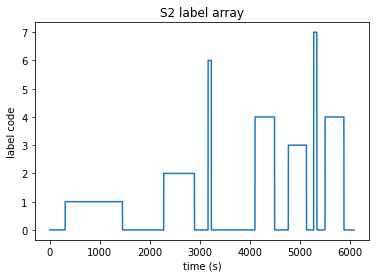

In [48]:
label_dict = {'0':'not defined/transient' ,'1':'baseline' ,'2':'stress' ,'3':'amusement' ,'4':'meditation' ,'5':'ignore' ,'6':'ignore' ,'7':'ignore' }
print(label_dict)

import matplotlib.pyplot as plt
plt.plot(np.linspace(0, 6079, len(S2_sensor_dict['label'])), S2_sensor_dict['label'])
plt.title(S2_sensor_dict['subject']+' label array')
plt.xlabel('time (s)')
plt.ylabel('label code')
plt.show()

#### Explore 'signal' channels

In [41]:
print('chest:', type(S2_sensor_dict['signal']['chest']))
print('wrist:',type(S2_sensor_dict['signal']['wrist']))
print('chest:',S2_sensor_dict['signal']['chest'].keys()) # Chest = RespiBAN data
print('wrist:',S2_sensor_dict['signal']['wrist'].keys()) # Wrist = Empatica E4 data

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])


In [42]:
print('Chest (RespiBAN) sensor')
for key in S2_sensor_dict['signal']['chest'].keys():
    print(key, type(S2_sensor_dict['signal']['chest'][key]), 'shape: ', S2_sensor_dict['signal']['chest'][key].shape)
    print(S2_sensor_dict['signal']['chest'][key][:2,:]) # Preview first 2 rows of each channel

Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (4255300, 3)
[[ 0.95539999 -0.222      -0.55799997]
 [ 0.92579997 -0.2216     -0.55379999]]
ECG <class 'numpy.ndarray'> shape:  (4255300, 1)
[[0.02142334]
 [0.02032471]]
EMG <class 'numpy.ndarray'> shape:  (4255300, 1)
[[-0.00444031]
 [ 0.00434875]]
EDA <class 'numpy.ndarray'> shape:  (4255300, 1)
[[5.25054932]
 [5.26733398]]
Temp <class 'numpy.ndarray'> shape:  (4255300, 1)
[[30.120758]
 [30.129517]]
Resp <class 'numpy.ndarray'> shape:  (4255300, 1)
[[-1.14898682]
 [-1.12457275]]


In [43]:
print('Wrist (Empatica E4) sensor')
for key in S2_sensor_dict['signal']['wrist'].keys():
    print(key, type(S2_sensor_dict['signal']['wrist'][key]), 'shape: ', S2_sensor_dict['signal']['wrist'][key].shape)
    print(S2_sensor_dict['signal']['wrist'][key][:2,:]) # Preview first 2 rows of each channel

Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (194528, 3)
[[ 62. -21. 107.]
 [ 66.  13.  53.]]
BVP <class 'numpy.ndarray'> shape:  (389056, 1)
[[-59.37]
 [-53.42]]
EDA <class 'numpy.ndarray'> shape:  (24316, 1)
[[1.138257]
 [1.125444]]
TEMP <class 'numpy.ndarray'> shape:  (24316, 1)
[[35.41]
 [35.41]]


##### chest sensor (RespiBAN) has all channels of consistent length, but no time stamps
##### wrist sensor (Empatica E4) has channels with inconsistent length, and no time stamps

In [44]:
# According to S2_E4_Data/info.txt about wrist Empatica E4 sensor:
# ACC signals are 32 Hz
# BVP signals are 64 Hz
# EDA signals are 4 Hz
# TEMP signals are 4 Hz

In [46]:
Hz_dict = {'ACC':32, 'BVP':64, 'EDA':4, 'TEMP':4}
for key in S2_sensor_dict['signal']['wrist'].keys():
    print(key, Hz_dict[key], 'Hz', 'for a total length of', S2_sensor_dict['signal']['wrist'][key].shape[0] / Hz_dict[key], 'seconds' )

ACC 32 Hz for a total length of 6079.0 seconds
BVP 64 Hz for a total length of 6079.0 seconds
EDA 4 Hz for a total length of 6079.0 seconds
TEMP 4 Hz for a total length of 6079.0 seconds


##### wrist sensor (Empatica E4) channels have consistent duration after dividing by sampling rate

In [47]:
# chest sensor channels are all sampled at 700 Hz
for key in S2_sensor_dict['signal']['chest'].keys():
    print(key, '700 Hz', 'for a total length of', S2_sensor_dict['signal']['chest'][key].shape[0] / 700, 'seconds' )

ACC 700 Hz for a total length of 6079.0 seconds
ECG 700 Hz for a total length of 6079.0 seconds
EMG 700 Hz for a total length of 6079.0 seconds
EDA 700 Hz for a total length of 6079.0 seconds
Temp 700 Hz for a total length of 6079.0 seconds
Resp 700 Hz for a total length of 6079.0 seconds


##### chest sensor channels have the same total duration as the wrist sensor. This is good.

#### .pkl file has 14 total signal variables within 10 numpy arrays between 2 devices, plus a label channel indicating the current task within the experimental session. It also indicates the subject ID.

### Wrangle the questionnaire/self-report data in SX_quest.csv

In [149]:
S_dict['S2'][3] #Confirm .csv file string

'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S2\\S2_quest.csv'

In [90]:
# Funky format: headers are on left and row lengths are uneven. Using csv module instead of pandas.
import csv

S2_quest_dict = dict()
repeated_measures = {'PANAS':0, 'STAI':0, 'DIM':0} #This will help in labeling the repeated measures


with open(S_dict['S2'][3], 'r') as S2_quest_file:
    for row in csv.reader(S2_quest_file, delimiter=';'):
        if '#' in row[0]:
            thisrow = [entry if '#' not in entry else entry[2:] for entry in row]
            stripped = False
            while stripped==False:
                try: thisrow.remove('')
                except: stripped = True
            print(thisrow)

            if thisrow[0] in repeated_measures.keys():
                thisrow[0] = thisrow[0] + '_' + S2_quest_dict['ORDER'][repeated_measures[thisrow[0]]] #Renames index value with corresponding task
                repeated_measures[thisrow[0].split('_')[0]] += 1
            
            row_header = thisrow[0]
            row_data = thisrow[1:]
            S2_quest_dict[row_header] = row_data

print('\n')
for key, value in S2_quest_dict.items():
    print(key, ':', value)


['Subj', 'S2']
['ORDER', 'Base', 'TSST', 'Medi 1', 'Fun', 'Medi 2', 'sRead', 'fRead']
['START', '7.08', '39.55', '70.19', '81.25', '93.38', '54.42', '89.51']
['END', '26.32', '50.3', '77.1', '87.47', '100.15', '56.07', '91.15']
['PANAS', '1', '1', '3', '2', '1', '3', '1', '1', '1', '2', '2', '2', '2', '1', '4', '3', '4', '4', '2', '2', '2', '1', '2', '1']
['PANAS', '3', '2', '4', '1', '3', '3', '1', '2', '1', '4', '2', '4', '3', '1', '5', '4', '4', '4', '2', '3', '3', '3', '2', '1', '3', '1']
['PANAS', '1', '1', '2', '3', '1', '2', '1', '1', '1', '1', '1', '1', '3', '1', '2', '1', '2', '3', '1', '1', '1', '1', '4', '1']
['PANAS', '1', '1', '2', '3', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '4', '1', '1', '3', '1', '1', '1', '2', '3', '1']
['PANAS', '1', '1', '1', '2', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '2', '1', '1', '2', '1', '1', '1', '1', '3', '1']
['STAI', '3', '2', '1', '4', '2', '3']
['STAI', '1', '3', '2', '1', '3', '1']
['STAI', '4', '1', '1', '4', '2', 

In [109]:
ORDER_df = pd.DataFrame(pd.Series(S2_quest_dict['START'], index=S2_quest_dict['ORDER'], name='START')).join(pd.Series(S2_quest_dict['END'], index=S2_quest_dict['ORDER'], name='END'))
print(ORDER_df) # Unit seems to be minutes

        START     END
Base     7.08   26.32
TSST    39.55    50.3
Medi 1  70.19    77.1
Fun     81.25   87.47
Medi 2  93.38  100.15
sRead   54.42   56.07
fRead   89.51   91.15


In [77]:
# Writing lists that will serve as index values
#PANAS is a 5 point scale (1-5)
PANAS_Base_list = 'Active Distressed Interested Inspired Annoyed Strong Guilty Scared Hostile Excited Proud Irritable Enthusiastic Ashamed Alert Nervous Determined Attentive Jittery Afraid Stressed Frustrated Happy Sad'
PANAS_Base_list = PANAS_Base_list.split(' ')
PANAS_TSST_list = 'Active Distressed Interested Inspired Annoyed Strong Guilty Scared Hostile Excited Proud Irritable Enthusiastic Ashamed Alert Nervous Determined Attentive Jittery Afraid Stressed Frustrated Happy Angry Irritated Sad'
PANAS_TSST_list = PANAS_TSST_list.split(' ')
#STAI is a 4 point scale (1-4)
STAI_list = ['I feel at ease', 'I feel nervous', 'I am jittery', 'I am relaxed', 'I am worried', 'I feel pleasant']
#DIM/SAM is a 9 point scale (1-9)
DIM_list = ['Valence', 'Arousal']
#SSSQ is a 5 point scale (1-5)
SSSQ_list = ['I was committed to attaining my performance goals', 'I wanted to succeed on the task', 'I was motivated to do the task',
            'I reflected about myself', 'I was worried about what other people think of me', 'I felt concerned about the impression I was making']

In [99]:
PANAS_TSST = pd.Series(S2_quest_dict['PANAS_TSST'], index=PANAS_TSST_list, name='TSST')
PANAS_Base = pd.Series(S2_quest_dict['PANAS_Base'], index=PANAS_Base_list, name='Base')
PANAS_Medi1 = pd.Series(S2_quest_dict['PANAS_Medi 1'], index=PANAS_Base_list, name='Medi 1')
PANAS_Fun = pd.Series(S2_quest_dict['PANAS_Fun'], index=PANAS_Base_list, name='Fun')
PANAS_Medi2 = pd.Series(S2_quest_dict['PANAS_Medi 2'], index=PANAS_Base_list, name='Medi 2')

PANAS_df = pd.DataFrame(PANAS_Base).join(PANAS_TSST, how='right').join(PANAS_Medi1, how='left').join(PANAS_Fun, how='left').join(PANAS_Medi2, how='left')
PANAS_df.index.name = 'PANAS'
print(PANAS_df)

             Base TSST Medi 1  Fun Medi 2
PANAS                                    
Active          1    3      1    1      1
Distressed      1    2      1    1      1
Interested      3    4      2    2      1
Inspired        2    1      3    3      2
Annoyed         1    3      1    1      1
Strong          3    3      2    1      1
Guilty          1    1      1    1      1
Scared          1    2      1    1      1
Hostile         1    1      1    1      1
Excited         2    4      1    1      1
Proud           2    2      1    1      1
Irritable       2    4      1    1      1
Enthusiastic    2    3      3    2      2
Ashamed         1    1      1    1      1
Alert           4    5      2    4      2
Nervous         3    4      1    1      1
Determined      4    4      2    1      1
Attentive       4    4      3    3      2
Jittery         2    2      1    1      1
Afraid          2    3      1    1      1
Stressed        2    3      1    1      1
Frustrated      1    3      1    2

In [114]:
STAI_df = pd.DataFrame({key:value for key, value in S2_quest_dict.items() if 'STAI' in key}, index=STAI_list)
STAI_df.columns = S2_quest_dict['ORDER'][:5]
print(STAI_df)

                Base TSST Medi 1 Fun Medi 2
I feel at ease     3    1      4   3      4
I feel nervous     2    3      1   1      1
I am jittery       1    2      1   1      1
I am relaxed       4    1      4   3      4
I am worried       2    3      2   1      1
I feel pleasant    3    1      4   4      4


In [115]:
DIM_df = pd.DataFrame({key:value for key, value in S2_quest_dict.items() if 'DIM' in key}, index=DIM_list)
DIM_df.columns = S2_quest_dict['ORDER'][:5]
print(DIM_df)

        Base TSST Medi 1 Fun Medi 2
Valence    7    5      7   8      7
Arousal    2    4      2   1      2


In [116]:
SSSQ_df = pd.Series(S2_quest_dict['SSSQ'], index=SSSQ_list, name='TSST') # Ratings about TSST (public speaking task)
print(SSSQ_df)

I was committed to attaining my performance goals     5
I wanted to succeed on the task                       5
I was motivated to do the task                        4
I reflected about myself                              4
I was worried about what other people think of me     3
I felt concerned about the impression I was making    5
Name: TSST, dtype: object


In [134]:
pd.set_option('display.max_columns', 50)  
pd.set_option('display.width', 120)
S2_Quest_df = ORDER_df.iloc[:5,:].T.append(PANAS_df).append(STAI_df).append(DIM_df).append(pd.DataFrame(SSSQ_df))
print(S2_Quest_df)

                                                     Base   TSST Medi 1    Fun  Medi 2
START                                                7.08  39.55  70.19  81.25   93.38
END                                                 26.32   50.3   77.1  87.47  100.15
Active                                                  1      3      1      1       1
Distressed                                              1      2      1      1       1
Interested                                              3      4      2      2       1
Inspired                                                2      1      3      3       2
Annoyed                                                 1      3      1      1       1
Strong                                                  3      3      2      1       1
Guilty                                                  1      1      1      1       1
Scared                                                  1      2      1      1       1
Hostile                                    

In [155]:
savepath = 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\'
S2_Quest_df.to_csv(savepath+'S2_Questions.csv')

### Extract personal info from SX_readme.txt into dictionary 'info_dict'

In [150]:
S_dict['S2'][4] #Confirm .txt file string

'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S2\\S2_readme.txt'

In [151]:
info_dict = dict()
with open(S_dict['S2'][4], 'r') as file:
    lines = file.readlines()
    count = 0
    for line in lines:
        count += 1
        print(line)
        if (count <= 6) and (count > 1):
            info_dict[str(line).split(':')[0]] = str(line).split(':')[1].strip()
        elif (count <= 14) and (count > 8):
            info_dict[str(line).split('?')[0]] = str(line).split('?')[1].strip()
        elif count > 16:
            info_dict['LINE_'+str(count)] = line

print('\n\n\n')
for k, v in info_dict.items(): 
    print(k,':', v)

### Personal information ###

Age: 27

Height (cm): 175

Weight (kg): 80

Gender: male

Dominant hand: right



### Study pre-requisites ###

Did you drink coffee today? NO

Did you drink coffee within the last hour? NO

Did you do any sports today? NO

Are you a smoker? NO

Did you smoke within the last hour? NO

Do you feel ill today? NO



### Additional notes ###

The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.





Age : 27
Height (cm) : 175
Weight (kg) : 80
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.



In [157]:
import json
with open(savepath+"S2_info.json", "w") as outfile:  
    json.dump(info_dict, outfile) 

## Do the above data checks with custom functions, so that individual subject data can be batch processed

In [70]:
def check_pkl_raw(Subj_ID, S_dict, pkl_index_in_S_dict=0, return_dict=False):
    """
    Check the coherence of raw sensor data and associated labels.
    Outputs dictionary if indicated. Raw data must be preprocessed before it can be downsampled.
    """
    import pandas as pd
    S2_sensor_dict = pd.read_pickle(S_dict[Subj_ID][pkl_index_in_S_dict]) # Load pickle file
    print(S2_sensor_dict.keys())

    # Check type, length, and superficial contents of each key's value
    for key in S2_sensor_dict.keys():
        print(type(S2_sensor_dict[key]), 'length:', len(S2_sensor_dict[key]))
    print('\n')
    print('SIGNAL KEYS:',S2_sensor_dict['signal'].keys())
    print('LABEL ARRAY LENGTH',S2_sensor_dict['label'].shape)
    print('SUBJECT #:',S2_sensor_dict['subject'])
    
    import numpy as np
    print(np.unique(S2_sensor_dict['label'])) # readme.pdf described this as labels for the different experimental segments within the research design
    
    Hz_dict = {'ACC':32, 'BVP':64, 'EDA':4, 'TEMP':4}
    label_dict = {'0':'not defined/transient' ,'1':'baseline' ,'2':'stress' ,'3':'amusement' ,'4':'meditation' ,'5':'ignore' ,'6':'ignore' ,'7':'ignore' }
    print(label_dict)

    import matplotlib.pyplot as plt
    plt.plot(np.linspace(0, 6079, len(S2_sensor_dict['label'])), S2_sensor_dict['label'])
    plt.title(S2_sensor_dict['subject']+' label array')
    plt.xlabel('time (s)')
    plt.ylabel('label code')
    plt.show()
    
    print('chest:', type(S2_sensor_dict['signal']['chest']))
    print('wrist:',type(S2_sensor_dict['signal']['wrist']))
    print('chest:',S2_sensor_dict['signal']['chest'].keys()) # Chest = RespiBAN data
    print('wrist:',S2_sensor_dict['signal']['wrist'].keys()) # Wrist = Empatica E4 data

    print('Chest (RespiBAN) sensor')
    for key in S2_sensor_dict['signal']['chest'].keys():
        print(key, type(S2_sensor_dict['signal']['chest'][key]), 'shape: ', S2_sensor_dict['signal']['chest'][key].shape)
        print(S2_sensor_dict['signal']['chest'][key][:2,:]) # Preview first 2 rows of each channel
        
    print('Wrist (Empatica E4) sensor')
    for key in S2_sensor_dict['signal']['wrist'].keys():
        print(key, type(S2_sensor_dict['signal']['wrist'][key]), 'shape: ', S2_sensor_dict['signal']['wrist'][key].shape)
        print(S2_sensor_dict['signal']['wrist'][key][:2,:]) # Preview first 2 rows of each channel
        
    
    for key in S2_sensor_dict['signal']['wrist'].keys():
        print(key, Hz_dict[key], 'Hz', 'for a total length of', S2_sensor_dict['signal']['wrist'][key].shape[0] / Hz_dict[key], 'seconds' )
        
    # chest sensor channels are all sampled at 700 Hz
    for key in S2_sensor_dict['signal']['chest'].keys():
        print(key, '700 Hz', 'for a total length of', S2_sensor_dict['signal']['chest'][key].shape[0] / 700, 'seconds' )
    
    if return_dict == True:
        return S2_sensor_dict


 SUBJECT ID: S2
dict_keys(['signal', 'label', 'subject'])
<class 'dict'> length: 2
<class 'numpy.ndarray'> length: 4255300
<class 'str'> length: 2


SIGNAL KEYS: dict_keys(['chest', 'wrist'])
LABEL ARRAY LENGTH (4255300,)
SUBJECT #: S2
[0 1 2 3 4 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


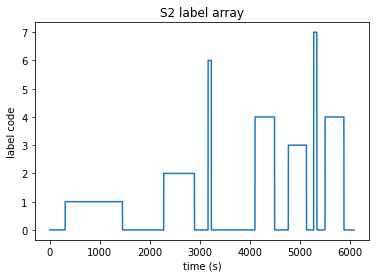

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (4255300, 3)
[[ 0.95539999 -0.222      -0.55799997]
 [ 0.92579997 -0.2216     -0.55379999]]
ECG <class 'numpy.ndarray'> shape:  (4255300, 1)
[[0.02142334]
 [0.02032471]]
EMG <class 'numpy.ndarray'> shape:  (4255300, 1)
[[-0.00444031]
 [ 0.00434875]]
EDA <class 'numpy.ndarray'> shape:  (4255300, 1)
[[5.25054932]
 [5.26733398]]
Temp <class 'numpy.ndarray'> shape:  (4255300, 1)
[[30.120758]
 [30.129517]]
Resp <class 'numpy.ndarray'> shape:  (4255300, 1)
[[-1.14898682]
 [-1.12457275]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (194528, 3)
[[ 62. -21. 107.]
 [ 66.  13.  53.]]
BVP <class 'numpy.ndarray'> shape:  (389056, 1)
[[-59.37]
 [-53.42]]
EDA <class 'numpy.ndarray'> shape:  (24316, 1)
[[1.138257]
 [1.125444]]
TEMP <class 'numpy.ndarray'> shape:  (24316, 1

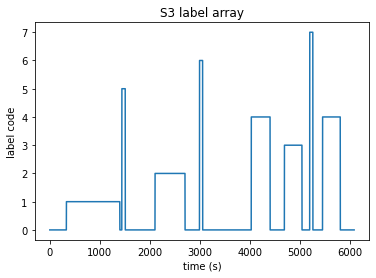

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (4545100, 3)
[[ 0.72000003 -0.13819999  3.19339991]
 [ 0.56879997 -0.22860003  3.18219995]]
ECG <class 'numpy.ndarray'> shape:  (4545100, 1)
[[-0.75663757]
 [-0.70820618]]
EMG <class 'numpy.ndarray'> shape:  (4545100, 1)
[[ 0.00595093]
 [-0.0385437 ]]
EDA <class 'numpy.ndarray'> shape:  (4545100, 1)
[[7.98835754]
 [7.98225403]]
Temp <class 'numpy.ndarray'> shape:  (4545100, 1)
[[31.499023]
 [31.501953]]
Resp <class 'numpy.ndarray'> shape:  (4545100, 1)
[[2.20489502]
 [2.18048096]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (207776, 3)
[[-128.  127.  127.]
 [ -41.   49.   76.]]
BVP <class 'numpy.ndarray'> shape:  (415552, 1)
[[16.49]
 [15.8 ]]
EDA <class 'numpy.ndarray'> shape:  (25972, 1)
[[2.248749]
 [2.710001]]
TEMP <class 'numpy.ndarray'> shape:  (2597

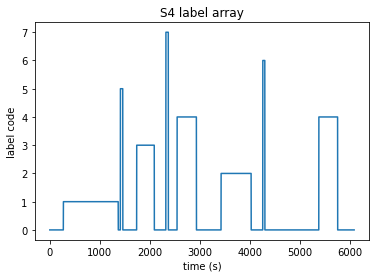

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (4496100, 3)
[[ 1.55539989 -0.07840002  1.36240005]
 [ 1.51300001 -0.10699999  1.45860004]]
ECG <class 'numpy.ndarray'> shape:  (4496100, 1)
[[-1.40538025]
 [-1.3996582 ]]
EMG <class 'numpy.ndarray'> shape:  (4496100, 1)
[[0.04417419]
 [0.01547241]]
EDA <class 'numpy.ndarray'> shape:  (4496100, 1)
[[1.09634399]
 [1.09443665]]
Temp <class 'numpy.ndarray'> shape:  (4496100, 1)
[[32.506256]
 [32.49878 ]]
Resp <class 'numpy.ndarray'> shape:  (4496100, 1)
[[2.83660889]
 [2.83966064]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (205536, 3)
[[-128.  122.   88.]
 [ -31.  -34.   77.]]
BVP <class 'numpy.ndarray'> shape:  (411072, 1)
[[-3.69]
 [-5.53]]
EDA <class 'numpy.ndarray'> shape:  (25692, 1)
[[0.169117]
 [0.164001]]
TEMP <class 'numpy.ndarray'> shape:  (25692,

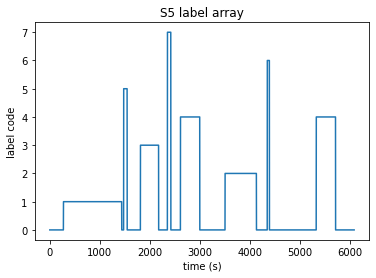

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (4380600, 3)
[[0.86059999 0.07420003 0.85699999]
 [0.84560001 0.07799995 0.85739994]]
ECG <class 'numpy.ndarray'> shape:  (4380600, 1)
[[-0.27580261]
 [-0.22975159]]
EMG <class 'numpy.ndarray'> shape:  (4380600, 1)
[[0.01679993]
 [0.01496887]]
EDA <class 'numpy.ndarray'> shape:  (4380600, 1)
[[3.88832092]
 [3.91311646]]
Temp <class 'numpy.ndarray'> shape:  (4380600, 1)
[[34.119934]
 [34.142822]]
Resp <class 'numpy.ndarray'> shape:  (4380600, 1)
[[0.04425049]
 [0.03204346]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (200256, 3)
[[-16. -45. 127.]
 [ 69.   9. 127.]]
BVP <class 'numpy.ndarray'> shape:  (400512, 1)
[[-7.25]
 [-8.57]]
EDA <class 'numpy.ndarray'> shape:  (25032, 1)
[[0.547723]
 [0.481218]]
TEMP <class 'numpy.ndarray'> shape:  (25032, 1)
[[34.09]

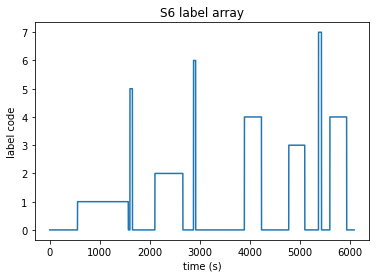

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (4949700, 3)
[[ 0.35099995 -0.19059998  2.28419995]
 [ 0.44219995 -0.1142      2.22160006]]
ECG <class 'numpy.ndarray'> shape:  (4949700, 1)
[[0.03337097]
 [0.03639221]]
EMG <class 'numpy.ndarray'> shape:  (4949700, 1)
[[0.05534363]
 [0.03877258]]
EDA <class 'numpy.ndarray'> shape:  (4949700, 1)
[[9.85984802]
 [9.8613739 ]]
Temp <class 'numpy.ndarray'> shape:  (4949700, 1)
[[33.037903]
 [33.04239 ]]
Resp <class 'numpy.ndarray'> shape:  (4949700, 1)
[[3.10668945]
 [3.11126709]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (226272, 3)
[[112. -19. 127.]
 [ 44.  18.  10.]]
BVP <class 'numpy.ndarray'> shape:  (452544, 1)
[[4.26]
 [3.12]]
EDA <class 'numpy.ndarray'> shape:  (28284, 1)
[[2.779563]
 [2.785958]]
TEMP <class 'numpy.ndarray'> shape:  (28284, 1)
[[30.0

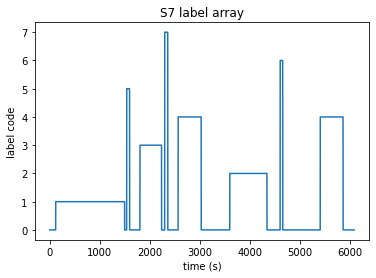

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (3666600, 3)
[[ 1.06960011 -0.014       1.4612    ]
 [ 1.06539989 -0.01020002  1.42219996]]
ECG <class 'numpy.ndarray'> shape:  (3666600, 1)
[[-0.01922607]
 [-0.01693726]]
EMG <class 'numpy.ndarray'> shape:  (3666600, 1)
[[-0.04884338]
 [-0.00700378]]
EDA <class 'numpy.ndarray'> shape:  (3666600, 1)
[[12.50686646]
 [12.46871948]]
Temp <class 'numpy.ndarray'> shape:  (3666600, 1)
[[33.99353]
 [33.93268]]
Resp <class 'numpy.ndarray'> shape:  (3666600, 1)
[[1.83258057]
 [1.83563232]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (167616, 3)
[[127. -50. 127.]
 [127.  46.  -8.]]
BVP <class 'numpy.ndarray'> shape:  (335232, 1)
[[9.57]
 [7.41]]
EDA <class 'numpy.ndarray'> shape:  (20952, 1)
[[5.969716]
 [6.1002  ]]
TEMP <class 'numpy.ndarray'> shape:  (20952, 1)
[[

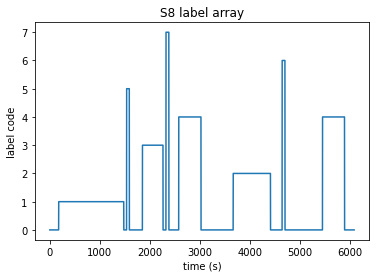

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (3826200, 3)
[[ 0.87460005 -0.02319998  0.27620006]
 [ 0.88020003 -0.01139998  0.26380002]]
ECG <class 'numpy.ndarray'> shape:  (3826200, 1)
[[0.16950989]
 [0.16639709]]
EMG <class 'numpy.ndarray'> shape:  (3826200, 1)
[[-0.00535583]
 [ 0.00993347]]
EDA <class 'numpy.ndarray'> shape:  (3826200, 1)
[[4.36859131]
 [4.37202454]]
Temp <class 'numpy.ndarray'> shape:  (3826200, 1)
[[34.264893]
 [34.28018 ]]
Resp <class 'numpy.ndarray'> shape:  (3826200, 1)
[[-1.71813965]
 [-1.71661377]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (174912, 3)
[[ -7. -15. -34.]
 [-38. 127. 127.]]
BVP <class 'numpy.ndarray'> shape:  (349824, 1)
[[-3.27]
 [ 6.25]]
EDA <class 'numpy.ndarray'> shape:  (21864, 1)
[[0.503081]
 [0.515874]]
TEMP <class 'numpy.ndarray'> shape:  (21864, 1)


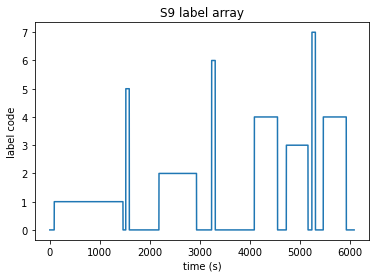

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (3656100, 3)
[[ 1.07859993 -0.10460001  0.57700002]
 [ 1.12420011 -0.09579998  0.55579996]]
ECG <class 'numpy.ndarray'> shape:  (3656100, 1)
[[-0.05058289]
 [-0.05680847]]
EMG <class 'numpy.ndarray'> shape:  (3656100, 1)
[[ 0.00091553]
 [-0.03337097]]
EDA <class 'numpy.ndarray'> shape:  (3656100, 1)
[[1.96113586]
 [1.97868347]]
Temp <class 'numpy.ndarray'> shape:  (3656100, 1)
[[33.68225 ]
 [33.704956]]
Resp <class 'numpy.ndarray'> shape:  (3656100, 1)
[[-0.98571777]
 [-0.9979248 ]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (167136, 3)
[[-128.  -55.  127.]
 [-128.   -3.   85.]]
BVP <class 'numpy.ndarray'> shape:  (334272, 1)
[[-10.02]
 [ -7.43]]
EDA <class 'numpy.ndarray'> shape:  (20892, 1)
[[0.329014]
 [0.326456]]
TEMP <class 'numpy.ndarray'> shape:  (

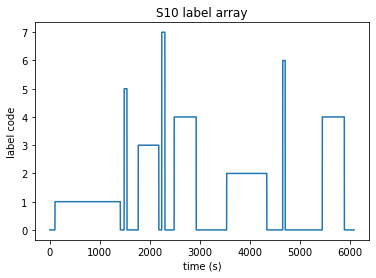

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (3847200, 3)
[[1.12779999 0.15199995 0.34159994]
 [1.09319997 0.18879998 0.29219997]]
ECG <class 'numpy.ndarray'> shape:  (3847200, 1)
[[-1.33369446]
 [-1.32774353]]
EMG <class 'numpy.ndarray'> shape:  (3847200, 1)
[[-0.01368713]
 [-0.02192688]]
EDA <class 'numpy.ndarray'> shape:  (3847200, 1)
[[0.71601868]
 [0.7144928 ]]
Temp <class 'numpy.ndarray'> shape:  (3847200, 1)
[[33.69586 ]
 [33.741333]]
Resp <class 'numpy.ndarray'> shape:  (3847200, 1)
[[0.21362305]
 [0.19226074]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (175872, 3)
[[ 107. -105.  127.]
 [  67.  -52.   45.]]
BVP <class 'numpy.ndarray'> shape:  (351744, 1)
[[10.17]
 [12.04]]
EDA <class 'numpy.ndarray'> shape:  (21984, 1)
[[0.349215]
 [0.346656]]
TEMP <class 'numpy.ndarray'> shape:  (21984, 1)


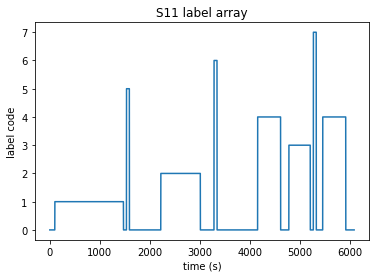

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (3663100, 3)
[[0.76740003 0.42260003 1.76620007]
 [0.73259997 0.28779995 1.72340012]]
ECG <class 'numpy.ndarray'> shape:  (3663100, 1)
[[0.02009583]
 [0.03684998]]
EMG <class 'numpy.ndarray'> shape:  (3663100, 1)
[[-0.01387024]
 [-0.00201416]]
EDA <class 'numpy.ndarray'> shape:  (3663100, 1)
[[6.60743713]
 [6.60324097]]
Temp <class 'numpy.ndarray'> shape:  (3663100, 1)
[[33.520264]
 [33.494537]]
Resp <class 'numpy.ndarray'> shape:  (3663100, 1)
[[2.12097168]
 [2.11334229]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (167456, 3)
[[-128.  127.  127.]
 [ -46.    2.   92.]]
BVP <class 'numpy.ndarray'> shape:  (334912, 1)
[[-12.14]
 [ -6.2 ]]
EDA <class 'numpy.ndarray'> shape:  (20932, 1)
[[4.4455  ]
 [4.911148]]
TEMP <class 'numpy.ndarray'> shape:  (20932, 1)


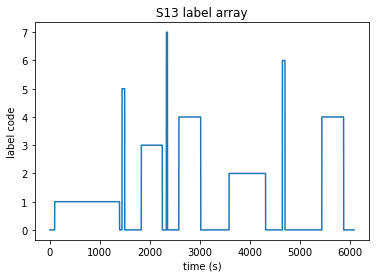

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (3875900, 3)
[[ 0.97259998 -0.14120001  0.23179996]
 [ 0.99100006 -0.08279997  0.20780003]]
ECG <class 'numpy.ndarray'> shape:  (3875900, 1)
[[-0.27278137]
 [-0.27104187]]
EMG <class 'numpy.ndarray'> shape:  (3875900, 1)
[[-0.00498962]
 [-0.04788208]]
EDA <class 'numpy.ndarray'> shape:  (3875900, 1)
[[2.34718323]
 [2.36778259]]
Temp <class 'numpy.ndarray'> shape:  (3875900, 1)
[[32.62726 ]
 [32.622772]]
Resp <class 'numpy.ndarray'> shape:  (3875900, 1)
[[0.050354  ]
 [0.40435791]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (177184, 3)
[[ 54. -57. 127.]
 [ 35.  50.  40.]]
BVP <class 'numpy.ndarray'> shape:  (354368, 1)
[[44.2 ]
 [42.39]]
EDA <class 'numpy.ndarray'> shape:  (22148, 1)
[[9.149161]
 [8.816556]]
TEMP <class 'numpy.ndarray'> shape:  (22148, 1)


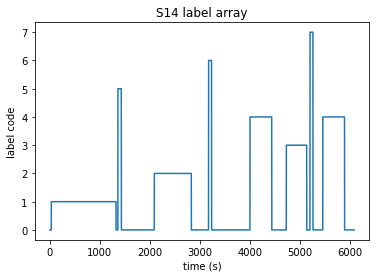

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (3883600, 3)
[[ 0.76540005 -0.18879998  0.3714    ]
 [ 0.71599996 -0.22960001  0.39499998]]
ECG <class 'numpy.ndarray'> shape:  (3883600, 1)
[[-0.17088318]
 [-0.15261841]]
EMG <class 'numpy.ndarray'> shape:  (3883600, 1)
[[0.01011658]
 [0.01194763]]
EDA <class 'numpy.ndarray'> shape:  (3883600, 1)
[[2.73895264]
 [2.72712708]]
Temp <class 'numpy.ndarray'> shape:  (3883600, 1)
[[32.8248]
 [32.8248]]
Resp <class 'numpy.ndarray'> shape:  (3883600, 1)
[[-1.33056641]
 [-1.3168335 ]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (177536, 3)
[[ -23.   31.  127.]
 [-128.  -31.   62.]]
BVP <class 'numpy.ndarray'> shape:  (355072, 1)
[[-8.27]
 [-9.52]]
EDA <class 'numpy.ndarray'> shape:  (22192, 1)
[[0.277864]
 [0.266351]]
TEMP <class 'numpy.ndarray'> shape:  (22192, 1

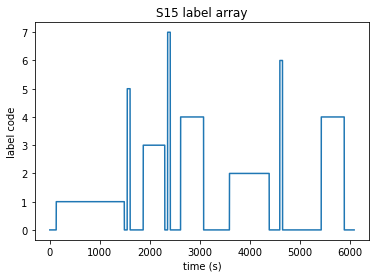

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (3676400, 3)
[[0.82959998 0.31219995 1.1473999 ]
 [0.83099997 0.29700005 1.23900008]]
ECG <class 'numpy.ndarray'> shape:  (3676400, 1)
[[-0.02554321]
 [-0.01295471]]
EMG <class 'numpy.ndarray'> shape:  (3676400, 1)
[[-0.01615906]
 [-0.0141449 ]]
EDA <class 'numpy.ndarray'> shape:  (3676400, 1)
[[1.36222839]
 [1.35765076]]
Temp <class 'numpy.ndarray'> shape:  (3676400, 1)
[[33.493042]
 [33.447693]]
Resp <class 'numpy.ndarray'> shape:  (3676400, 1)
[[0.69122314]
 [0.6942749 ]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (168064, 3)
[[ 40. -45. 127.]
 [127.  33.  54.]]
BVP <class 'numpy.ndarray'> shape:  (336128, 1)
[[1.35]
 [1.15]]
EDA <class 'numpy.ndarray'> shape:  (21008, 1)
[[0.220298]
 [0.170407]]
TEMP <class 'numpy.ndarray'> shape:  (21008, 1)
[[29.79]

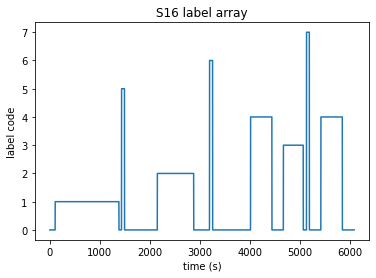

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (3941700, 3)
[[0.71599996 0.08560002 1.6184001 ]
 [0.60759997 0.03919995 1.51920009]]
ECG <class 'numpy.ndarray'> shape:  (3941700, 1)
[[0.05278015]
 [0.01853943]]
EMG <class 'numpy.ndarray'> shape:  (3941700, 1)
[[-0.03744507]
 [ 0.00682068]]
EDA <class 'numpy.ndarray'> shape:  (3941700, 1)
[[0.96321106]
 [0.94642639]]
Temp <class 'numpy.ndarray'> shape:  (3941700, 1)
[[33.405396]
 [33.42804 ]]
Resp <class 'numpy.ndarray'> shape:  (3941700, 1)
[[-1.38397217]
 [-1.39770508]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (180192, 3)
[[ 86. -38. 112.]
 [-40.  26.  -5.]]
BVP <class 'numpy.ndarray'> shape:  (360384, 1)
[[-1.6 ]
 [-2.09]]
EDA <class 'numpy.ndarray'> shape:  (22524, 1)
[[0.254602]
 [0.253322]]
TEMP <class 'numpy.ndarray'> shape:  (22524, 1)
[[29.4

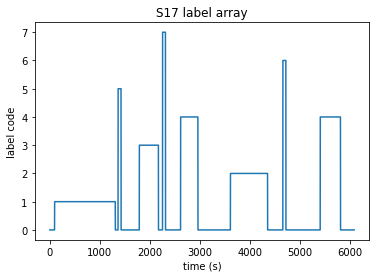

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (4144000, 3)
[[ 0.70019996 -0.19819999 -1.07019997]
 [ 0.72940004 -0.19019997 -1.04700005]]
ECG <class 'numpy.ndarray'> shape:  (4144000, 1)
[[1.43179321]
 [1.46195984]]
EMG <class 'numpy.ndarray'> shape:  (4144000, 1)
[[ 0.00709534]
 [-0.0124054 ]]
EDA <class 'numpy.ndarray'> shape:  (4144000, 1)
[[5.40046692]
 [5.40885925]]
Temp <class 'numpy.ndarray'> shape:  (4144000, 1)
[[32.415283]
 [32.43463 ]]
Resp <class 'numpy.ndarray'> shape:  (4144000, 1)
[[3.22113037]
 [3.60717773]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (189440, 3)
[[ -36.  -38. -128.]
 [  -9.   -9.    2.]]
BVP <class 'numpy.ndarray'> shape:  (378880, 1)
[[-0.49]
 [-0.38]]
EDA <class 'numpy.ndarray'> shape:  (23680, 1)
[[2.015176]
 [2.012617]]
TEMP <class 'numpy.ndarray'> shape:  (23680,

In [165]:
# Check that all sensor pkl files have even length and that task labels are as expected
for subject in S_dict.keys():
    print('\n', 'SUBJECT ID:', subject)
    check_pkl_raw(Subj_ID=subject, S_dict=S_dict)

### batch process self-report questionnaires

In [172]:
def process_questionnaires(Subj_ID, S_dict, savepath):
    """
    Combines questionnaires into a single dataframe, then saves it as .csv
    """
    # Funky format: headers are on left and row lengths are uneven. Using csv module instead of pandas.
    import csv

    S2_quest_dict = dict()
    repeated_measures = {'PANAS':0, 'STAI':0, 'DIM':0} #This will help in labeling the repeated measures


    with open(S_dict[Subj_ID][3], 'r') as S2_quest_file:
        for row in csv.reader(S2_quest_file, delimiter=';'):
            if '#' in row[0]:
                thisrow = [entry if '#' not in entry else entry[2:] for entry in row]
                stripped = False
                while stripped==False:
                    try: thisrow.remove('')
                    except: stripped = True
                #print(thisrow)

                if thisrow[0] in repeated_measures.keys():
                    thisrow[0] = thisrow[0] + '_' + S2_quest_dict['ORDER'][repeated_measures[thisrow[0]]] #Renames index value with corresponding task
                    repeated_measures[thisrow[0].split('_')[0]] += 1

                row_header = thisrow[0]
                row_data = thisrow[1:]
                S2_quest_dict[row_header] = row_data

    #print('\n')
    #for key, value in S2_quest_dict.items():
        #print(key, ':', value)
        
    ORDER_df = pd.DataFrame(pd.Series(S2_quest_dict['START'], index=S2_quest_dict['ORDER'], name='START')).join(pd.Series(S2_quest_dict['END'], index=S2_quest_dict['ORDER'], name='END'))
    #print(ORDER_df) # Unit seems to be minutes
    
    # Writing lists that will serve as index values
    #PANAS is a 5 point scale (1-5)
    PANAS_Base_list = 'Active Distressed Interested Inspired Annoyed Strong Guilty Scared Hostile Excited Proud Irritable Enthusiastic Ashamed Alert Nervous Determined Attentive Jittery Afraid Stressed Frustrated Happy Sad'
    PANAS_Base_list = PANAS_Base_list.split(' ')
    PANAS_TSST_list = 'Active Distressed Interested Inspired Annoyed Strong Guilty Scared Hostile Excited Proud Irritable Enthusiastic Ashamed Alert Nervous Determined Attentive Jittery Afraid Stressed Frustrated Happy Angry Irritated Sad'
    PANAS_TSST_list = PANAS_TSST_list.split(' ')
    #STAI is a 4 point scale (1-4)
    STAI_list = ['I feel at ease', 'I feel nervous', 'I am jittery', 'I am relaxed', 'I am worried', 'I feel pleasant']
    #DIM/SAM is a 9 point scale (1-9)
    DIM_list = ['Valence', 'Arousal']
    #SSSQ is a 5 point scale (1-5)
    SSSQ_list = ['I was committed to attaining my performance goals', 'I wanted to succeed on the task', 'I was motivated to do the task',
                'I reflected about myself', 'I was worried about what other people think of me', 'I felt concerned about the impression I was making']
    
    PANAS_TSST = pd.Series(S2_quest_dict['PANAS_TSST'], index=PANAS_TSST_list, name='TSST')
    PANAS_Base = pd.Series(S2_quest_dict['PANAS_Base'], index=PANAS_Base_list, name='Base')
    PANAS_Medi1 = pd.Series(S2_quest_dict['PANAS_Medi 1'], index=PANAS_Base_list, name='Medi 1')
    PANAS_Fun = pd.Series(S2_quest_dict['PANAS_Fun'], index=PANAS_Base_list, name='Fun')
    PANAS_Medi2 = pd.Series(S2_quest_dict['PANAS_Medi 2'], index=PANAS_Base_list, name='Medi 2')

    PANAS_df = pd.DataFrame(PANAS_Base).join(PANAS_TSST, how='right').join(PANAS_Medi1, how='left').join(PANAS_Fun, how='left').join(PANAS_Medi2, how='left')
    PANAS_df.index.name = 'PANAS'
    #print(PANAS_df)
    
    STAI_df = pd.DataFrame({key:value for key, value in S2_quest_dict.items() if 'STAI' in key}, index=STAI_list)
    STAI_df.columns = S2_quest_dict['ORDER'][:5]
    #print(STAI_df)
    
    DIM_df = pd.DataFrame({key:value for key, value in S2_quest_dict.items() if 'DIM' in key}, index=DIM_list)
    DIM_df.columns = S2_quest_dict['ORDER'][:5]
    #print(DIM_df)
    
    SSSQ_df = pd.Series(S2_quest_dict['SSSQ'], index=SSSQ_list, name='TSST') # Ratings about TSST (public speaking task)
    #print(SSSQ_df)
    
    pd.set_option('display.max_columns', 50)  
    pd.set_option('display.width', 120)
    S2_Quest_df = ORDER_df.iloc[:5,:].T.append(PANAS_df).append(STAI_df).append(DIM_df).append(pd.DataFrame(SSSQ_df))
    print(S2_Quest_df)
    
    S2_Quest_df.to_csv(savepath+Subj_ID+'_Questions.csv')

In [173]:
#Check that questionnaire data is coherent for all participants, regardless of task order. Save single dataframe for all participants.
for subject in S_dict.keys():
    print('\n', 'SUBJECT ID:', subject)
    process_questionnaires(Subj_ID=subject, S_dict=S_dict, savepath=savepath)


 SUBJECT ID: S2
                                                     Base   TSST Medi 1    Fun  Medi 2
START                                                7.08  39.55  70.19  81.25   93.38
END                                                 26.32   50.3   77.1  87.47  100.15
Active                                                  1      3      1      1       1
Distressed                                              1      2      1      1       1
Interested                                              3      4      2      2       1
Inspired                                                2      1      3      3       2
Annoyed                                                 1      3      1      1       1
Strong                                                  3      3      2      1       1
Guilty                                                  1      1      1      1       1
Scared                                                  1      2      1      1       1
Hostile                   

##### S5 has an unexpected missing value for 'Nervous' represented by 'Nan' (fixed and saved later in notebook)

### batch process person-level variables from each SX_readme.txt

In [198]:
def process_subject_info(Subj_ID, S_dict, savepath):
    """
    This replicates the earlier steps in the notebook to process personal info.
    No output variable, but there is a saved file.
    """
    info_dict = dict()
    with open(S_dict[Subj_ID][4], 'r') as file:
        lines = file.readlines()
        count = 0
        for line in lines:
            count += 1
            #print(line)
            if (count <= 6) and (count > 1):
                info_dict[str(line).split(':')[0]] = str(line).split(':')[1].strip()
            elif (count <= 14) and (count > 8):
                info_dict[str(line).split('?')[0]] = str(line).split('?')[1].strip()
            elif count > 16:
                info_dict['LINE_'+str(count)] = line

    #print('\n\n\n')
    for k, v in info_dict.items(): 
        print(k,':', v)
        
    import json
    with open(savepath+Subj_ID+"_info.json", "w") as outfile:  
        json.dump(info_dict, outfile) 

In [199]:
#Check that personal info data is coherent for all participants. Save individual json files with info for all participants.
for subject in S_dict.keys():
    print('\n', 'SUBJECT ID:', subject)
    process_subject_info(Subj_ID=subject, S_dict=S_dict, savepath=savepath)


 SUBJECT ID: S2
Age : 27
Height (cm) : 175
Weight (kg) : 80
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.


 SUBJECT ID: S3
Age : 27
Height (cm) : 173
Weight (kg) : 69
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : During the baseline condition, the subject was sitting in a sunny workplace.

LINE_18 : Subject provided a valence label of 7 after the stress condition, claiming that he was looking forward to the next condition and was therefore cheerful.


 SUBJECT ID: S4
Age : 25
Height

##### S5 might have fallen asleep during the first meditation
##### S2 and S17 may have invalid temperature signals from the RespiBAN (chest) sensor

In [180]:
Questionnaire_files = glob(savepath+'*csv')
Questionnaire_files

['D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S10_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S11_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S13_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S14_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S15_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S16_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S17_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S2_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S3_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S4_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S5_Questions.csv',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S6_Questions.csv',
 'D:\\Spr

In [181]:
Info_files = glob(savepath+'*json')
Info_files

['D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S10_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S11_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S13_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S14_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S15_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S16_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S17_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S2_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S3_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S4_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S5_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S6_info.json',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\int

In [189]:
pkl_files = [v[0] for k,v in S_dict.items()]
pkl_files

['D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S2\\S2.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S3\\S3.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S4\\S4.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S5\\S5.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S6\\S6.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S7\\S7.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S8\\S8.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S9\\S9.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S10\\S10.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S11\\S11.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S13\\S13.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S14\\S14.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S15\\S15.pkl',
 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\

In [192]:
new_dict = {Subj_ID:[] for Subj_ID in S_dict.keys()}

for ID in new_dict.keys():
    pkl = [file for file in pkl_files if ID in file]
    questions = [file for file in Questionnaire_files if ID in file]
    info = [file for file in Info_files if ID in file] 
    new_dict[ID] = pkl + questions + info
new_dict

{'S2': ['D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S2\\S2.pkl',
  'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S2_Questions.csv',
  'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S2_info.json'],
 'S3': ['D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S3\\S3.pkl',
  'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S3_Questions.csv',
  'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S3_info.json'],
 'S4': ['D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S4\\S4.pkl',
  'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S4_Questions.csv',
  'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S4_info.json'],
 'S5': ['D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\S5\\S5.pkl',
  'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S5_Questions.csv',
  'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\S5_info.json'],
 'S6': ['D:\\Springboard\\Capsto

In [194]:
#Save JSON with data file paths
import json
with open(savepath+"ALL_FILE_PATHS.json", "w") as outfile:  
    json.dump(new_dict, outfile) 

# This is my break point for day 1. Tomorrow I will investigate the individual sensor features and check for out-of-range data in questionnaires.

In [1]:
#Day 2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
pd.set_option('display.max_columns', 50)  
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', 100)

In [9]:
interim_data_path = 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\interim\\'
ALL_FILE_PATHS = pd.read_json(interim_data_path+'ALL_FILE_PATHS.json')
print(ALL_FILE_PATHS)

                                                                       S2  \
0             D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2.pkl   
1  D:\Springboard\Capstone2\WESAD\Capstone2\data\interim\S2_Questions.csv   
2      D:\Springboard\Capstone2\WESAD\Capstone2\data\interim\S2_info.json   

                                                                       S3  \
0             D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S3\S3.pkl   
1  D:\Springboard\Capstone2\WESAD\Capstone2\data\interim\S3_Questions.csv   
2      D:\Springboard\Capstone2\WESAD\Capstone2\data\interim\S3_info.json   

                                                                       S4  \
0             D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S4\S4.pkl   
1  D:\Springboard\Capstone2\WESAD\Capstone2\data\interim\S4_Questions.csv   
2      D:\Springboard\Capstone2\WESAD\Capstone2\data\interim\S4_info.json   

                                                                       S5

### Checking Questionnaire data for out-of-range errors (none found) or improperly formatted missing values (one found and corrected)

Text(0.5, 1.0, 'S2 Checking for out-of-range errors')

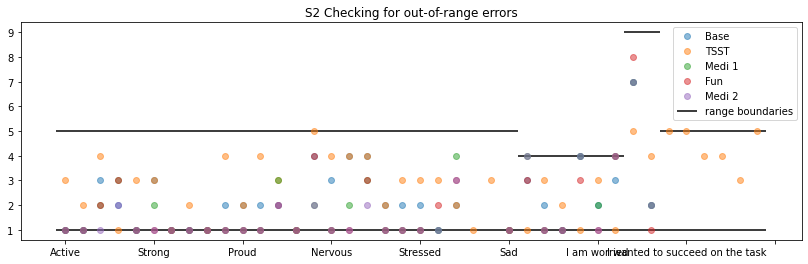

In [64]:
S2_Q = pd.read_csv(ALL_FILE_PATHS['S2'][1], index_col=0)
S2_Q.iloc[2:,:].plot(figsize=[14,4], alpha=0.5, marker='o', linestyle=' ')
plt.hlines([1,5,1,4,1,9,1,5],[-0.5,-0.5,25.5,25.5,31.5,31.5,33.5,33.5],[25.5,25.5,31.5,31.5,33.5,33.5,39.5,39.5], color='k', label='range boundaries')
plt.legend()
plt.title('S2'+' Checking for out-of-range errors')

### Visual inspection shows No out-of-range errors for questionnaires

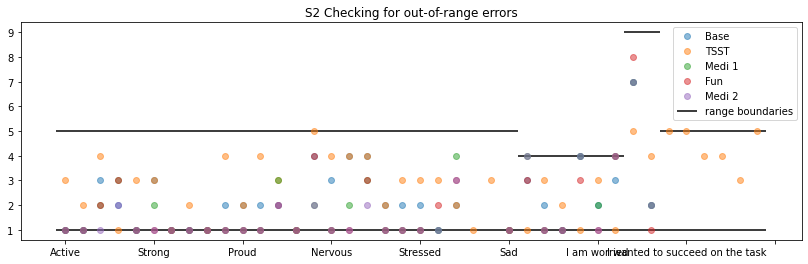

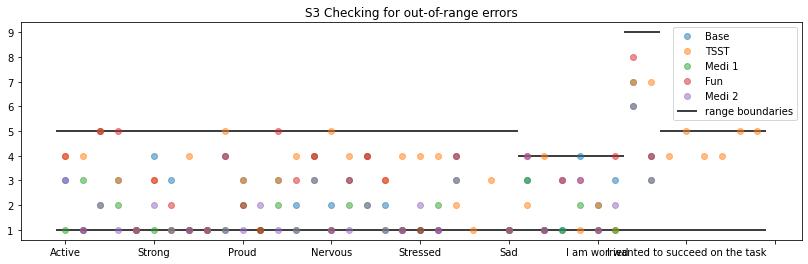

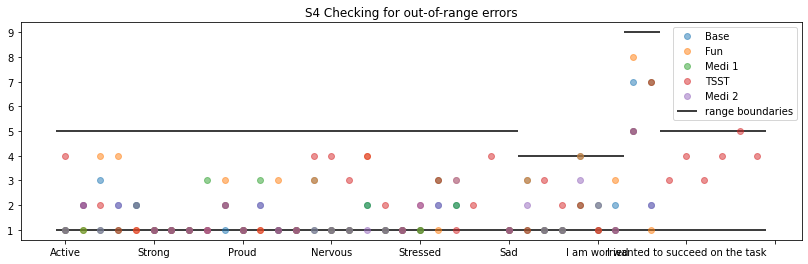

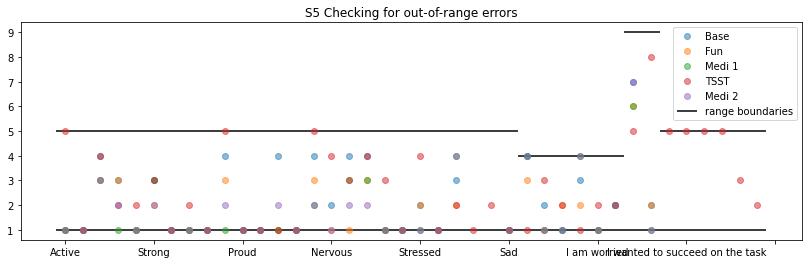

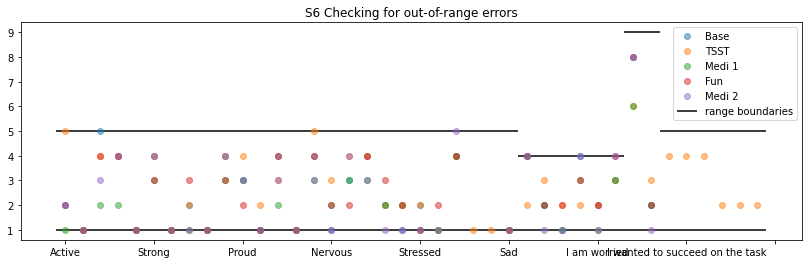

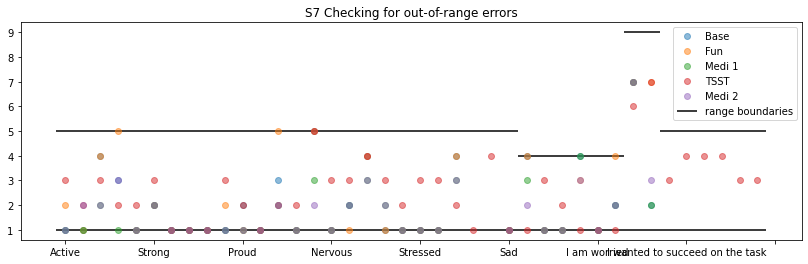

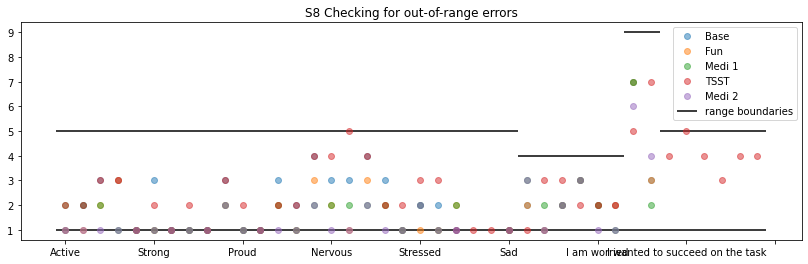

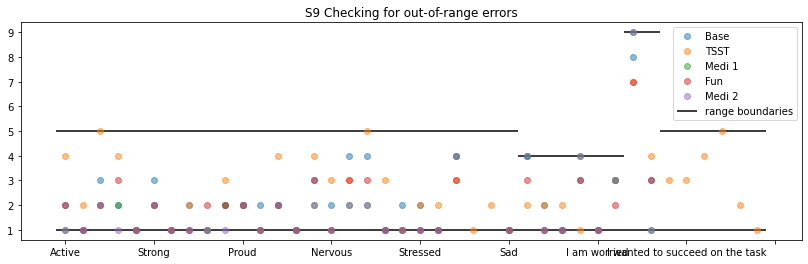

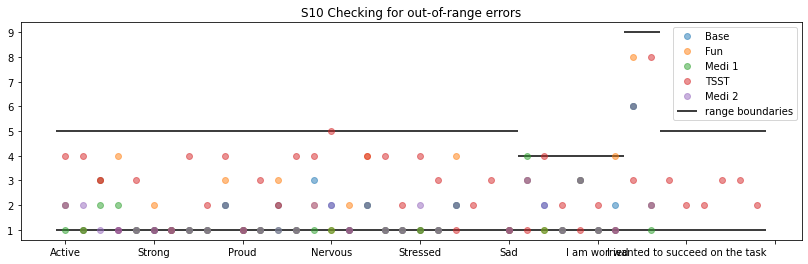

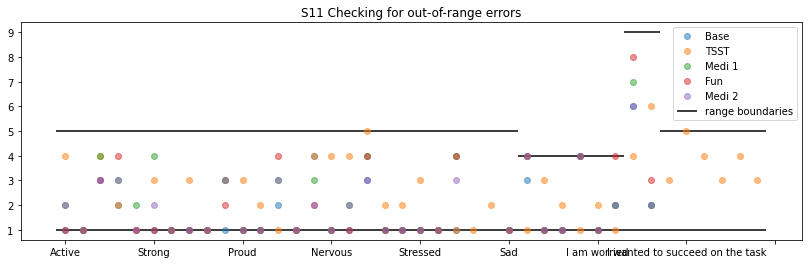

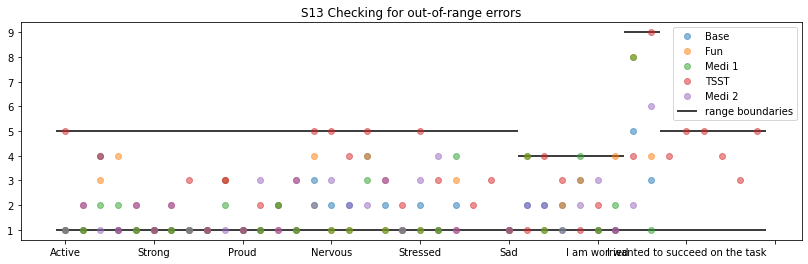

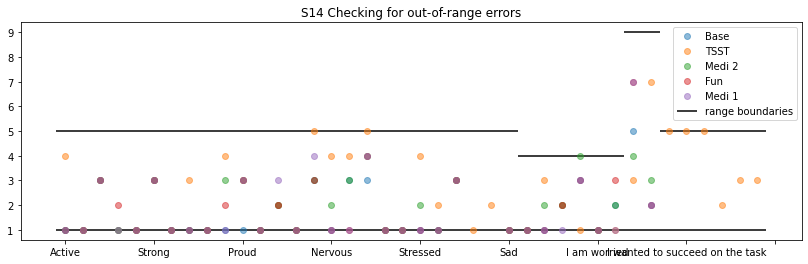

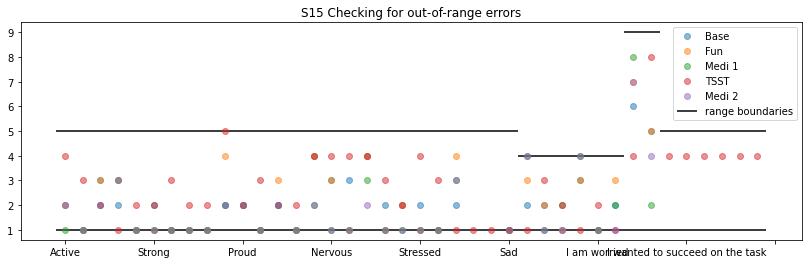

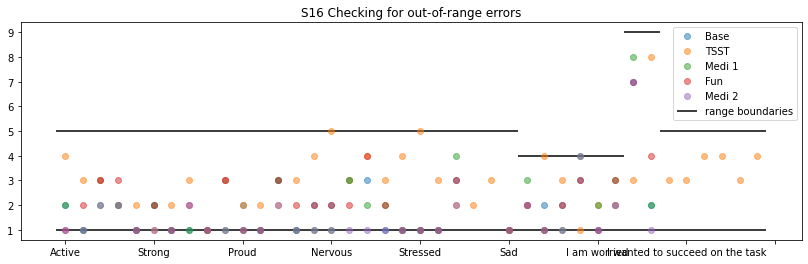

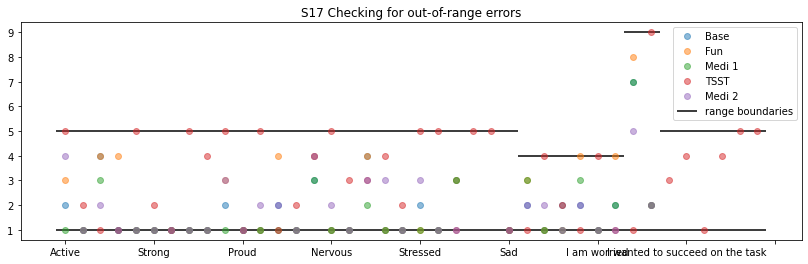

In [58]:
Qdict = dict() # Create QDict for easy access within notebook
for Subj_ID in ALL_FILE_PATHS.keys():
    Qdict[Subj_ID] = pd.read_csv(ALL_FILE_PATHS[Subj_ID][1], index_col=0)
    Qdict[Subj_ID].iloc[2:,:].plot(figsize=[14,4], alpha=0.5, marker='o', linestyle=' ')
    plt.hlines([1,5,1,4,1,9,1,5],[-0.5,-0.5,25.5,25.5,31.5,31.5,33.5,33.5],[25.5,25.5,31.5,31.5,33.5,33.5,39.5,39.5], color='k', label='range boundaries')
    plt.legend()
    plt.title(Subj_ID+' Checking for out-of-range errors')
    plt.show()

In [54]:
print(Qdict['S5'].loc['Nervous',:])
print(Qdict['S5'].loc['Nervous',:].isnull() )

Base        2
Fun         1
Medi 1    Nan
TSST        4
Medi 2      1
Name: Nervous, dtype: object
Base      False
Fun       False
Medi 1    False
TSST      False
Medi 2    False
Name: Nervous, dtype: bool


In [59]:
Qdict['S5'] = Qdict['S5'].replace('Nan', np.nan) #Convert the one missing value to a true NaN (np.nan)
print(Qdict['S5'].loc['Nervous',:])
print(Qdict['S5'].loc['Nervous',:].isnull() )

Base      2.0
Fun       1.0
Medi 1    NaN
TSST      4.0
Medi 2    1.0
Name: Nervous, dtype: float64
Base      False
Fun       False
Medi 1     True
TSST      False
Medi 2    False
Name: Nervous, dtype: bool


In [56]:
Qdict['S5'].to_csv(ALL_FILE_PATHS['S5'][1]) #Save interim dataframe file again with corrected null

## Time to characterize features in signal channels! :)

In [66]:
Hz_dict = {'ACC':32, 'BVP':64, 'EDA':4, 'TEMP':4}
label_dict = {'0':'not defined/transient' ,'1':'baseline' ,'2':'stress' ,'3':'amusement' ,'4':'meditation' ,'5':'ignore' ,'6':'ignore' ,'7':'ignore' }

In [71]:
check_pkl_raw?

Signature: check_pkl_raw(Subj_ID, S_dict, pkl_index_in_S_dict=0, return_dict=False)
Docstring:
Check the coherence of raw sensor data and associated labels.
Outputs dictionary if indicated. Raw data must be preprocessed before it can be downsampled.
File:      d:\springboard\capstone2\wesad\capstone2\notebooks\<ipython-input-70-d3fa63455361>
Type:      function


In [78]:
type(ALL_FILE_PATHS)
print(ALL_FILE_PATHS['S2'][0])

D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2.pkl


dict_keys(['signal', 'label', 'subject'])
<class 'dict'> length: 2
<class 'numpy.ndarray'> length: 4255300
<class 'str'> length: 2


SIGNAL KEYS: dict_keys(['chest', 'wrist'])
LABEL ARRAY LENGTH (4255300,)
SUBJECT #: S2
[0 1 2 3 4 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


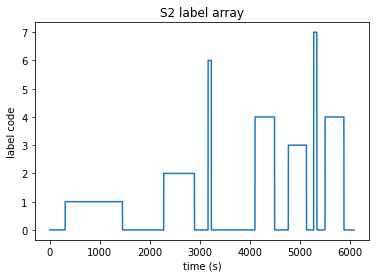

chest: <class 'dict'>
wrist: <class 'dict'>
chest: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
Chest (RespiBAN) sensor
ACC <class 'numpy.ndarray'> shape:  (4255300, 3)
[[ 0.95539999 -0.222      -0.55799997]
 [ 0.92579997 -0.2216     -0.55379999]]
ECG <class 'numpy.ndarray'> shape:  (4255300, 1)
[[0.02142334]
 [0.02032471]]
EMG <class 'numpy.ndarray'> shape:  (4255300, 1)
[[-0.00444031]
 [ 0.00434875]]
EDA <class 'numpy.ndarray'> shape:  (4255300, 1)
[[5.25054932]
 [5.26733398]]
Temp <class 'numpy.ndarray'> shape:  (4255300, 1)
[[30.120758]
 [30.129517]]
Resp <class 'numpy.ndarray'> shape:  (4255300, 1)
[[-1.14898682]
 [-1.12457275]]
Wrist (Empatica E4) sensor
ACC <class 'numpy.ndarray'> shape:  (194528, 3)
[[ 62. -21. 107.]
 [ 66.  13.  53.]]
BVP <class 'numpy.ndarray'> shape:  (389056, 1)
[[-59.37]
 [-53.42]]
EDA <class 'numpy.ndarray'> shape:  (24316, 1)
[[1.138257]
 [1.125444]]
TEMP <class 'numpy.ndarray'> shape:  (24316, 1

In [79]:
S2_sensor_dict = check_pkl_raw('S2', ALL_FILE_PATHS, return_dict=True)
print(S2_sensor_dict.keys())

In [99]:
from sys import getsizeof
getsizeof(S2_sensor_dict)
{key: S2_sensor_dict['signal']['chest'][key] for key in ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']}

{'ECG': array([[ 0.02142334],
        [ 0.02032471],
        [ 0.01652527],
        ...,
        [-0.00544739],
        [ 0.00013733],
        [ 0.0040741 ]]),
 'EMG': array([[-0.00444031],
        [ 0.00434875],
        [ 0.00517273],
        ...,
        [-0.01716614],
        [-0.02897644],
        [-0.02357483]]),
 'EDA': array([[5.25054932],
        [5.26733398],
        [5.24330139],
        ...,
        [0.36048889],
        [0.36582947],
        [0.365448  ]]),
 'Temp': array([[30.120758],
        [30.129517],
        [30.138214],
        ...,
        [31.459229],
        [31.484283],
        [31.456268]], dtype=float32),
 'Resp': array([[-1.14898682],
        [-1.12457275],
        [-1.15203857],
        ...,
        [-1.10321045],
        [-1.08642578],
        [-1.09710693]])}

In [114]:
time_index = np.linspace(0,6079, len(S2_sensor_dict['signal']['chest']['ECG']) )
chest_df = pd.DataFrame({key: list(S2_sensor_dict['signal']['chest'][key]) for key in ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']}, index=time_index).astype('float')
chest_df = pd.concat([chest_df, pd.Series(list(S2_sensor_dict['label']), name='label', index=time_index)], axis=1)
chest_df = pd.concat([chest_df, pd.DataFrame({ 'ACC_x':list(S2_sensor_dict['signal']['chest']['ACC'][:,0]), 'ACC_y':list(S2_sensor_dict['signal']['chest']['ACC'][:,1]), 'ACC_z':list(S2_sensor_dict['signal']['chest']['ACC'][:,2]) }, index=time_index).astype('float') ], axis=1 )
print(chest_df.head())
print(chest_df.info())

               ECG       EMG       EDA       Temp      Resp  label   ACC_x   ACC_y   ACC_z
0.000000  0.021423 -0.004440  5.250549  30.120758 -1.148987      0  0.9554 -0.2220 -0.5580
0.001429  0.020325  0.004349  5.267334  30.129517 -1.124573      0  0.9258 -0.2216 -0.5538
0.002857  0.016525  0.005173  5.243301  30.138214 -1.152039      0  0.9082 -0.2196 -0.5392
0.004286  0.016708  0.007187  5.249405  30.129517 -1.158142      0  0.8974 -0.2102 -0.5122
0.005714  0.011673 -0.015152  5.286407  30.130951 -1.161194      0  0.8882 -0.2036 -0.4824
<class 'pandas.core.frame.DataFrame'>
Float64Index: 4255300 entries, 0.0 to 6079.0
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ECG     float64
 1   EMG     float64
 2   EDA     float64
 3   Temp    float64
 4   Resp    float64
 5   label   int64  
 6   ACC_x   float64
 7   ACC_y   float64
 8   ACC_z   float64
dtypes: float64(8), int64(1)
memory usage: 324.7 MB
None


### Plotting these channels from the chest sensor is good. 
* ECG (electrocardiogram) is not optimal (the heart's full waveform is not visible), but the peak is clear enough to work with
* EMG (electromyography) appears to be okay. Heart activity (ECG) causes artifacts.
* EDA (electrodermal activity)... the frequency of noise changes over time, and I'm not sure why. Also the range at the start is much higher than the range later.
* Temp (Temperature) seems to have low frequency noise and high frequency noise. We would not expect substantial sub-second changes in body temperature.
* Resp (Respiration) is fairly good quality. Should be preprocessed with median-based denoising.
* ACC (accelerometer) seems okay. Smooth at start. Then noisy later.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

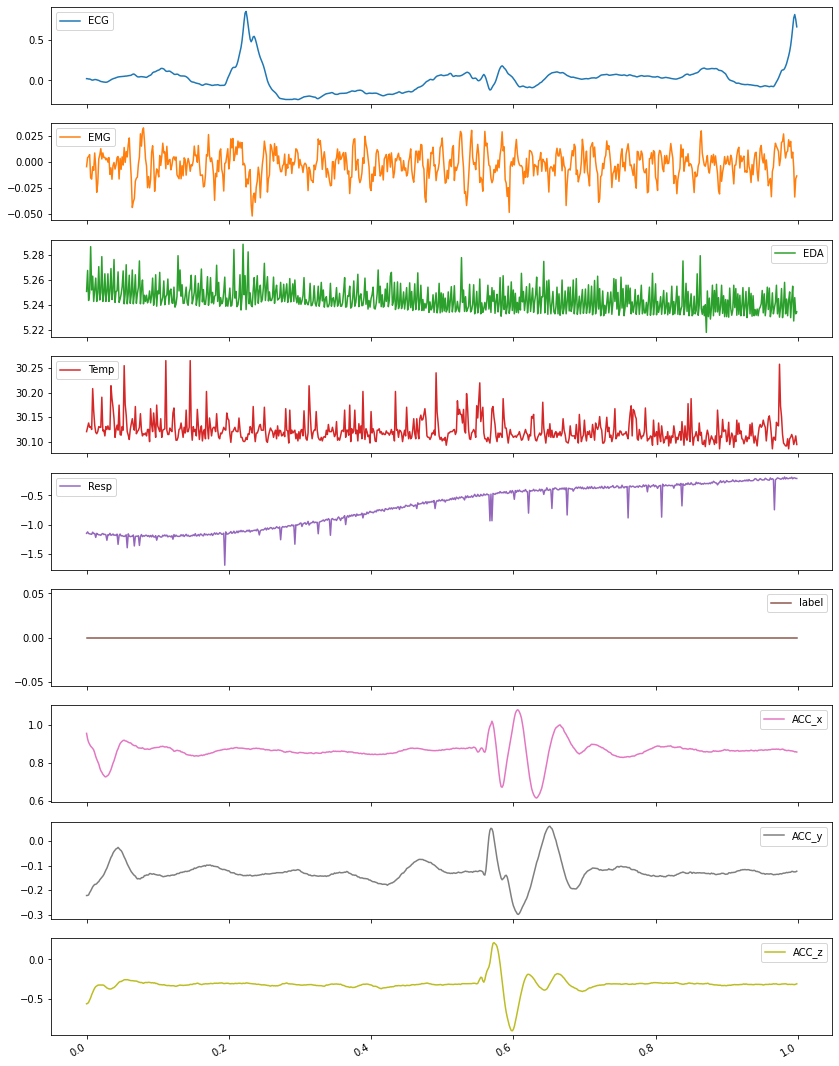

In [117]:
chest_df.iloc[:700,:].plot(subplots=True, figsize=[14,21]) #FIRST SECOND

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

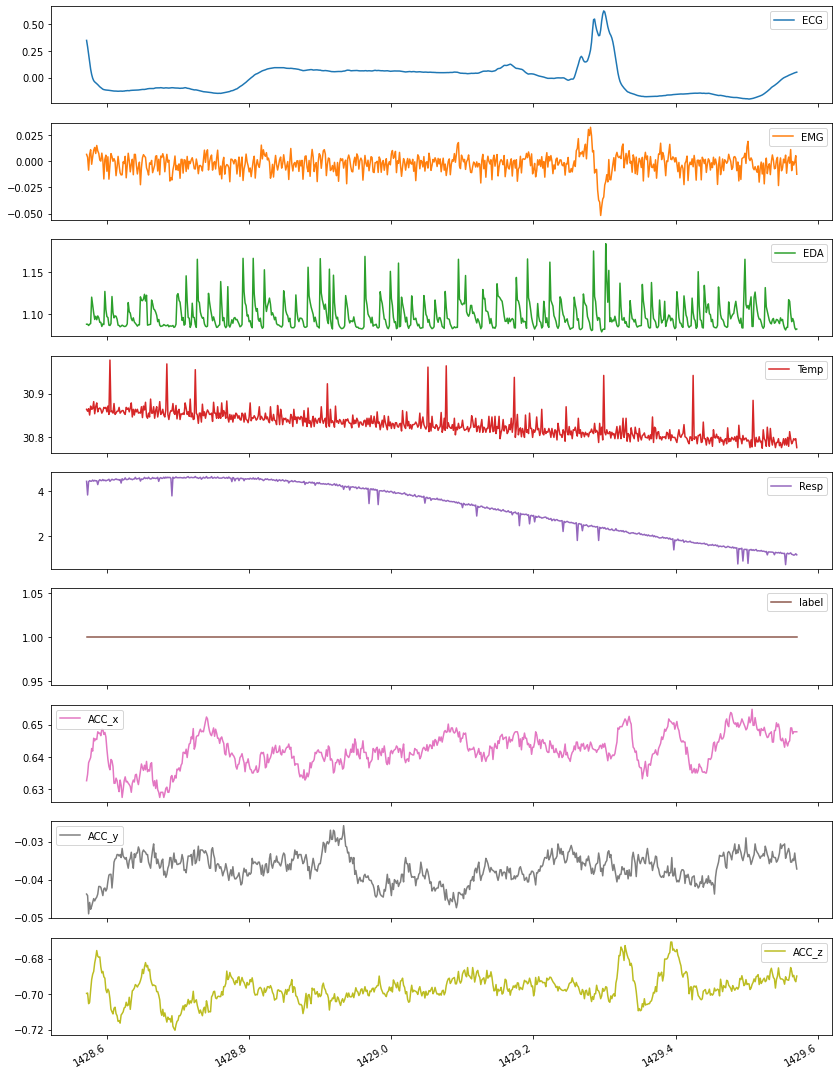

In [162]:
chest_df.iloc[1000000:1000700,:].plot(subplots=True, figsize=[14,21]) #ONE SECOND DURATION MUCH LATER IN EXPERIMENT

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

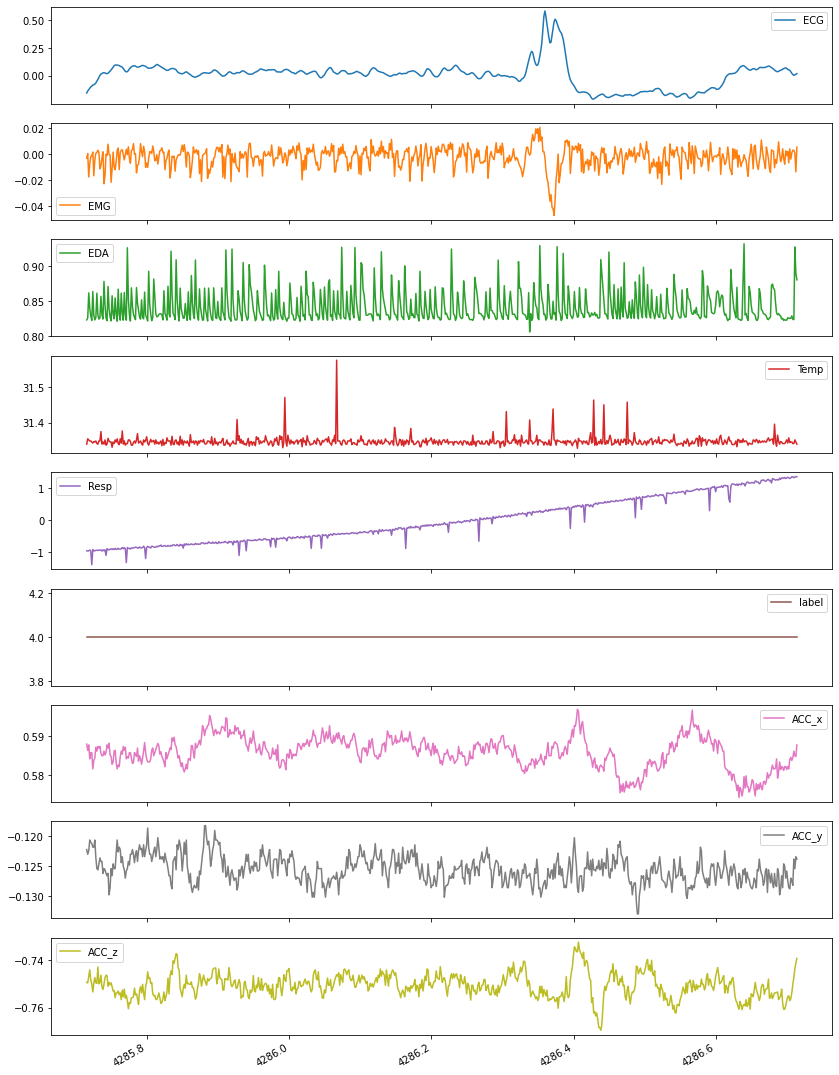

In [119]:
chest_df.iloc[3000000:3000700,:].plot(subplots=True, figsize=[14,21]) #AND EVEN LATER (during paced-breathing meditation)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

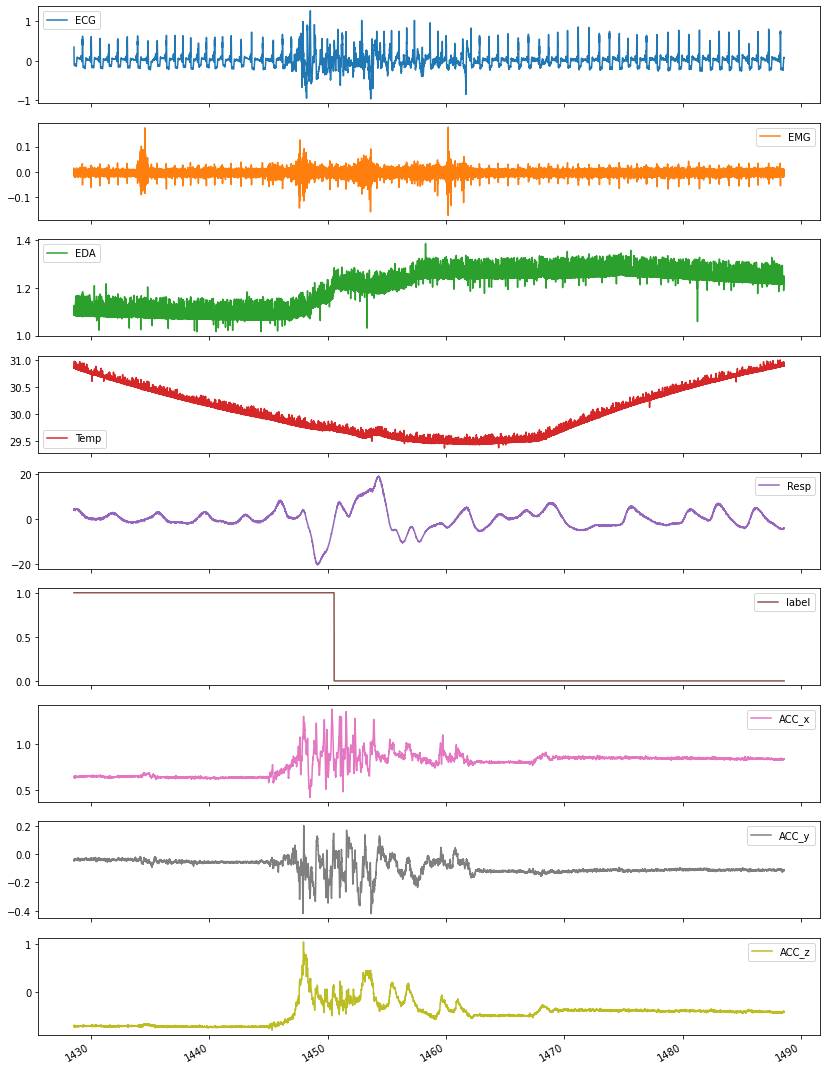

In [146]:
chest_df.iloc[1000000:1042000,:].plot(subplots=True, figsize=[14,21]) #FULL MINUTE DURING BASELINE

In [139]:
events_delta = chest_df['label'].diff().reset_index()
print(events_delta['label'].value_counts())
print('\nBaseline start at index:', int(events_delta[events_delta.values == 1].index.values))
print('\nBaseline end at index:', int(events_delta[events_delta.values == -1].index.values))
print('\nStress start at index:', int(events_delta[events_delta.values == 2].index.values))
print('\nStress end at index:', int(events_delta[events_delta.values == -2].index.values))
print('\nAmusement start at index:', int(events_delta[events_delta.values == 3].index.values))
print('\nAmusement end at index:', int(events_delta[events_delta.values == -3].index.values))
print('\nMeditation start at index:', events_delta[events_delta.values == 4].index.values)
print('\nMeditation end at index:', events_delta[events_delta.values == -4].index.values)

 0.0    4255285
-4.0          2
 4.0          2
-7.0          1
 1.0          1
-6.0          1
-1.0          1
-3.0          1
 7.0          1
 6.0          1
 3.0          1
-2.0          1
 2.0          1
Name: label, dtype: int64

Baseline start at index: 214583

Baseline end at index: 1015383

Stress start at index: 1591482

Stress end at index: 2021982

Amusement start at index: 3334483

Amusement end at index: 3587883

Meditation start at index: [2868283 3847583]

Meditation end at index: [3141982 4111483]


### Chest sensor plots during entire social stress task

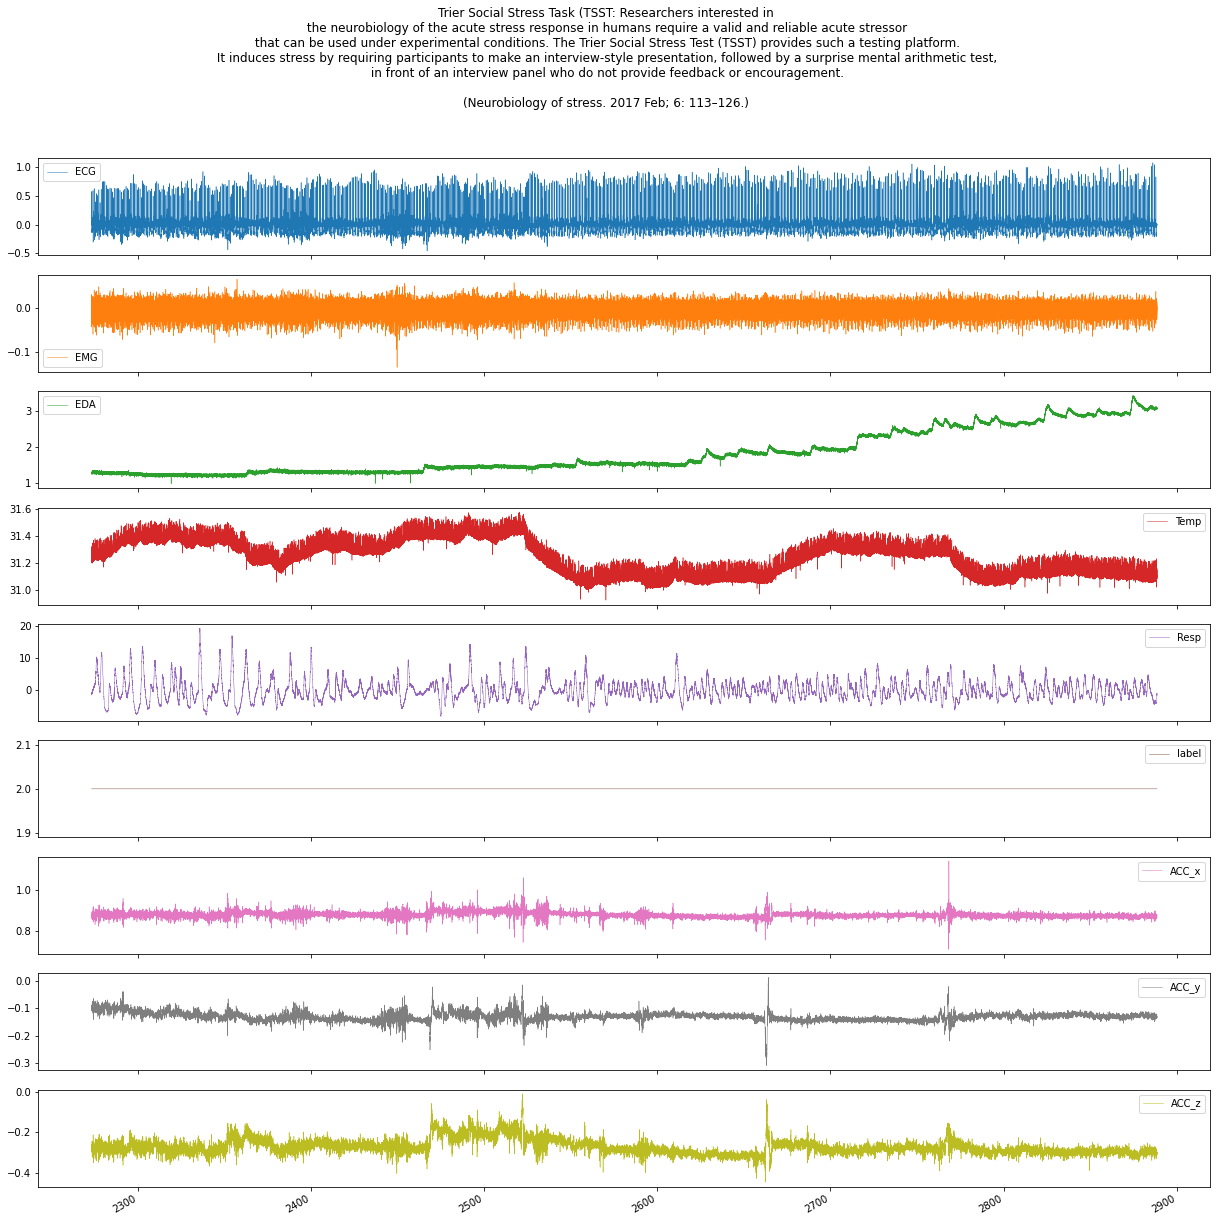

In [153]:
chest_df.iloc[1591482:2021982,:].plot(subplots=True, figsize=[21,21], linewidth=0.5,
                                     title='Trier Social Stress Task (TSST: Researchers interested in\n the neurobiology of the acute stress response in humans require a valid and reliable acute stressor\n that can be used under experimental conditions. The Trier Social Stress Test (TSST) provides such a testing platform.\n It induces stress by requiring participants to make an interview-style presentation, followed by a surprise mental arithmetic test,\n in front of an interview panel who do not provide feedback or encouragement.\n\n(Neurobiology of stress. 2017 Feb; 6: 113–126.)')
                                        #ENTIRE PUBLIC SPEAKING/STRESS TASK
plt.show()

## Conclusions from chest sensor for subject S2:
### ECG is imperfect, but it's definitely good enough to extract heart beats
### EMG looks okay. I need to look up exactly how to preprocess it before I know for sure.
### That EDA channel shows EXACTLY what I'd expect from sympathetic nervous system arousal during a stressful experience!
### Temp channel seems unreliable
### Resp channel shows interesting changes from start to end of stress task. The first half of the task is public speaking, and the second half is arithmetic with unamused onlookers. The difference in respiration probably reflects continuous speaking in first half, then less speaking and more thinking in the second half.
### Accelerometer is functional but noisy

# Now for the Wrist EMPATICA E4 SENSOR DATA

In [142]:
globals().keys() # What's the one that just shows names? .keys() method

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'json', 'np', 'pd', 'plt', '_i2', 'interim_data_path', 'ALL_FILE_PATHS', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_i10', '_10', '_i11', '_i12', '_12', '_i13', 'S2_Q', '_13', '_i14', '_14', '_i15', '_15', '_i16', '_i17', '_17', '_i18', '_18', '_i19', '_19', '_i20', '_20', '_i21', '_21', '_i22', '_22', '_i23', '_23', '_i24', '_24', '_i25', '_25', '_i26', '_26', '_i27', '_27', '_i28', '_28', '_i29', 'Subj_ID', '_i30', '_i31', '_i32', '_i33', '_i34', '_i35', '_i36', '_i37', '_i38', '_i39', '_39', '_i40', '_40', '_i41', '_41', '_i42', '_i43', 'Qdict', '_i44', '_44', '_i45', '_45', '_i46', '_46', '_i47', '_47', '_i48', '_i49', '_49', '_i50', '_50', '_i51', '_51', '_i52', '_52', '_i53', '_i54', '_i55', '_i56', '_i57', '_57', '_i58', '_i59', '_i60', '_i61', '_i62', '_62',

In [164]:
print( S2_sensor_dict['signal']['wrist'].keys() )
print ('\nSampling Frequencies:\n',{key:str(value)+' Hz' for key,value in Hz_dict.items()})
for (k, v), (k_sig, v_sig) in zip(Hz_dict.items(), S2_sensor_dict['signal']['wrist'].items()):
    print('\n'+str(k)+' Array Length of '+str(v_sig.shape[0])+' divided by '+str(v)+' equals '+str(v_sig.shape[0]/v)+' seconds total' )

dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

Sampling Frequencies:
 {'ACC': '32 Hz', 'BVP': '64 Hz', 'EDA': '4 Hz', 'TEMP': '4 Hz'}

ACC Array Length of 194528 divided by 32 equals 6079.0 seconds total

BVP Array Length of 389056 divided by 64 equals 6079.0 seconds total

EDA Array Length of 24316 divided by 4 equals 6079.0 seconds total

TEMP Array Length of 24316 divided by 4 equals 6079.0 seconds total


In [205]:
# PLOTTING WRIST CHANNELS

# formula for calculating time center of sample:
# 0.25 sampling period has a centers of 0.125, 0.375, ..., end_time - 0.375, end_time - 0.125
# np.linspace( sp/2 , end - (sp/2) , len(signal_array) ) # Where sp is sampling period
# sp = 1/sf # Where sf is sampling frequency
# sf = Hz_dict[key]

def plot_wrist_channels(raw_pkl_dictionary, xlims = (0, 1), title=''):
    """
    Plots the channels from the Empatica 4 on the subjects wrist
    Inputs:: 
    raw_pkl_dictionary: dictionary directly from original pkl file
    xlims: x-limits for plotting
    """
    fig, axes = plt.subplots(6,1,figsize=[14,12])
    fig.suptitle(title)
    #How big should the markers be?
    if xlims[1]-xlims[0] < 2 : markers = 'o'
    elif xlims[1]-xlims[0] < 10 : markers = '.'
    else : markers = ''
        
    for key, signal in raw_pkl_dictionary['signal']['wrist'].items():
        sf = Hz_dict[key]
        sp = 1/sf
        time_points = np.linspace( sp/2 , 6079 - (sp/2) , signal.shape[0] )

        if key=='ACC':
            ACC_x = signal[:,0]
            ACC_y = signal[:,1]
            ACC_z = signal[:,2]

            for ax, acc, c, name in zip(axes[:3], [ACC_x, ACC_y, ACC_z], ['r','g','b'], ['ACC_x', 'ACC_y', 'ACC_z']):
                ax.plot(time_points, acc, color=c, marker=markers, label=name)
                #ax.hlines(y=[p for p in acc[:100]], xmin=[t-(sp/2) for t in time_points[:100]], xmax=[t+(sp/2) for t in time_points[:100]], color='k', linewidth=2)
                ax.set_xlim(*xlims)
                ax.legend(loc = 'upper right')
            #plt.show()
        else:
            if key=='BVP': ax = axes[3]
            elif key=='EDA': ax = axes[4]
            elif key=='TEMP': ax = axes[5]
            ax.plot(time_points, signal, marker=markers, label=key)
            #plt.hlines(y=[p for p in signal[:100]], xmin=[t-(sp/2) for t in time_points[:100]], xmax=[t+(sp/2) for t in time_points[:100]], color='k', linewidth=2)
            ax.set_xlim(*xlims)
            ax.legend(loc = 'upper right')
    plt.show()

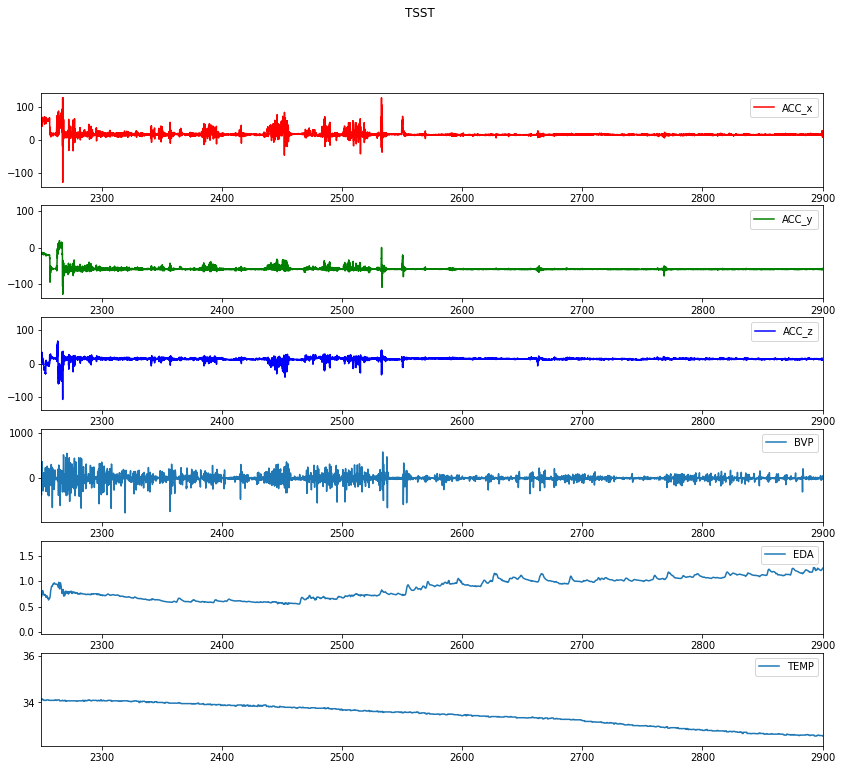

In [207]:
plot_wrist_channels(S2_sensor_dict, xlims = (2250, 2900), title='TSST')

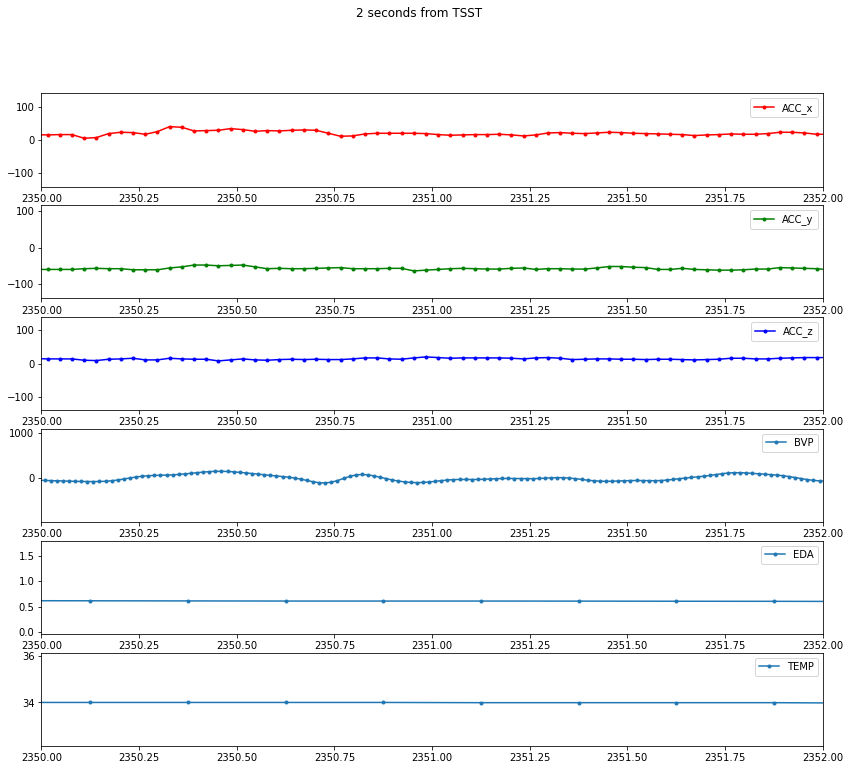

In [210]:
plot_wrist_channels(S2_sensor_dict, xlims = (2350, 2352), title='2 seconds from TSST')

         Base    TSST  Medi 1     Fun  Medi 2
START   424.8  2373.0  4211.4  4875.0  5602.8
END    1579.2  3018.0  4626.0  5248.2  6009.0


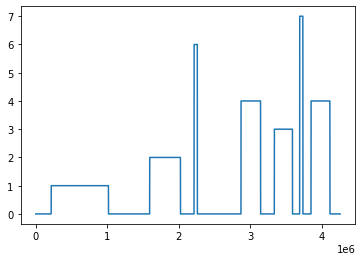

In [218]:
print(60 * Qdict['S2'].loc[['START','END'],:])

plt.plot(S2_sensor_dict['label'])

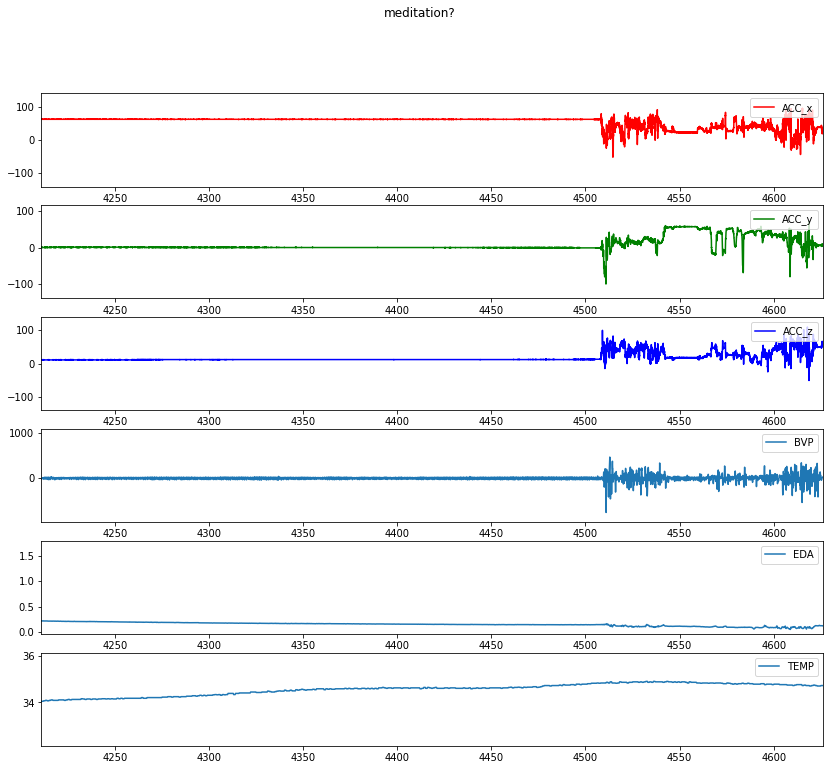

In [219]:
plot_wrist_channels(S2_sensor_dict, xlims=(4211, 4626), title='meditation?')

## Wrist sensor conclusions for subject S2:
### Acceloromter on wrist is ironically less noisy than on the chest.
### BVP appears to be unreliable to detect heart rate.
### EDA will be useful in supplementing the chest sensor measure of EDA.
### TEMP appears unreliable on both devices. Or maybe I just need more info to understand it.

In [260]:
# describe for all channels
for outerkey, device_dict in S2_sensor_dict['signal'].items():
    print(outerkey)
    if outerkey=='chest':
        print(pd.DataFrame({k:v.ravel() for k, v in device_dict.items() if v.shape[1]==1}, index=range(device_dict['ECG'].shape[0])).describe())
        print(pd.DataFrame(device_dict['ACC'], index=range(device_dict['ACC'].shape[0]), columns=['ACC_x','ACC_y','ACC_z']).describe())
    elif outerkey=='wrist':
        print(pd.DataFrame(device_dict['ACC'], index=range(device_dict['ACC'].shape[0]), columns=['ACC_x','ACC_y','ACC_z']).describe())
        for k, v in device_dict.items() :
            if k != 'ACC':
                print(k, pd.DataFrame(v.ravel()).describe())
            

chest
                ECG           EMG           EDA          Temp          Resp
count  4.255300e+06  4.255300e+06  4.255300e+06  4.255300e+06  4.255300e+06
mean   1.212245e-03 -2.412918e-03  1.528387e+00  3.087667e+01  5.490614e-02
std    1.540773e-01  1.165187e-02  1.238425e+00  1.281106e+00  2.917749e+00
min   -1.499542e+00 -4.149628e-01  2.632141e-01  2.804526e+01 -2.790375e+01
25%   -6.797791e-02 -8.331299e-03  7.995605e-01  3.057495e+01 -1.481628e+00
50%    8.239746e-03 -1.602173e-03  1.163101e+00  3.128992e+01 -1.571655e-01
75%    4.435730e-02  3.982544e-03  1.546478e+00  3.181512e+01  1.618958e+00
max    1.499313e+00  3.009796e-01  7.576752e+00  3.437039e+01  2.737885e+01
              ACC_x         ACC_y         ACC_z
count  4.255300e+06  4.255300e+06  4.255300e+06
mean   7.538656e-01 -1.331884e-01 -4.226812e-01
std    1.751162e-01  6.417297e-02  3.002357e-01
min    2.150000e-01 -6.600000e-01 -1.135400e+00
25%    6.210001e-01 -1.498000e-01 -7.172000e-01
50%    8.568000e-01 -1

chest


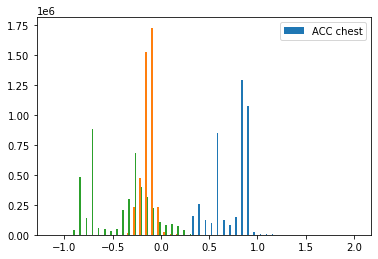

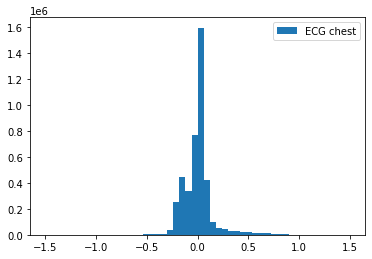

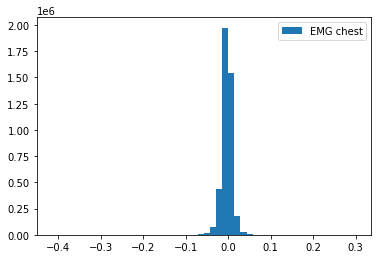

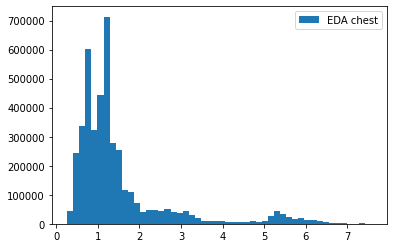

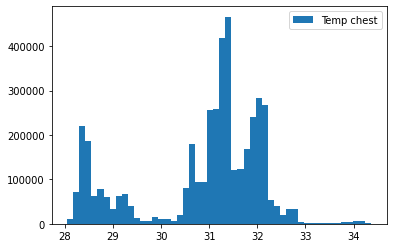

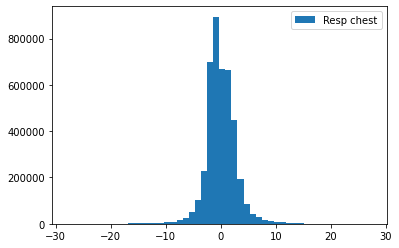

wrist


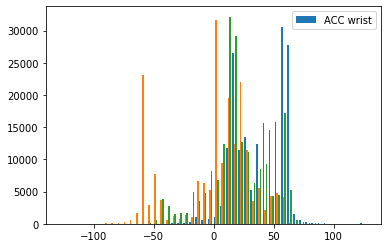

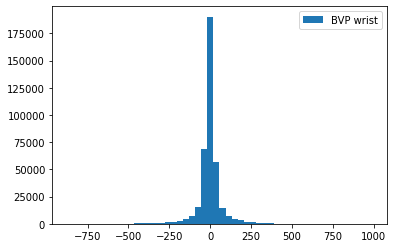

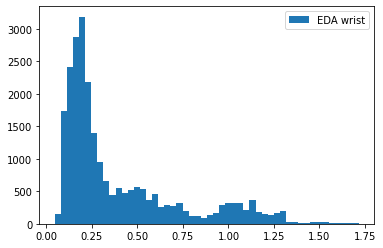

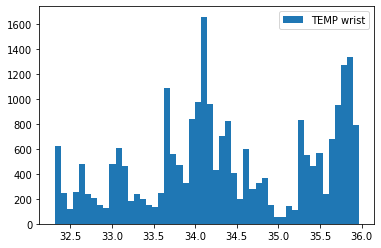

In [225]:
# Histogram for all channels
for outerkey, device_dict in S2_sensor_dict['signal'].items():
    print(outerkey)
    for key, signal in device_dict.items():
        plt.hist(signal, bins=50, label=key+' '+outerkey)
        plt.legend()
        plt.show()

# Overall conclusions:
## Most channels appear to be helpful, although they will all require some type of preprocessing
## BVP may be unhelpful (poor signal to noise ratio)
## TEMP measures appear to be unreliable
## ACC (accelerometer) is less noisy on wrist device than chest device
## Self-report data is high quality